# 데이터 시각화를 통해 인사이트 추출하기


# import

In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm



In [3]:
train_df = pd.read_csv('../dataset/new_train.csv')
test_df = pd.read_csv('../dataset/new_test.csv')

train_df.shape, test_df.shape

((32470, 12), (7765, 12))

### Basics

In [4]:
train_df.columns, test_df.columns

(Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
        'subject_start_idx', 'subject_end_idx', 'subject_type',
        'object_start_idx', 'object_end_idx', 'object_type'],
       dtype='object'),
 Index(['id', 'sentence', 'subject_entity', 'object_entity', 'label', 'source',
        'subject_start_idx', 'subject_end_idx', 'subject_type',
        'object_start_idx', 'object_end_idx', 'object_type'],
       dtype='object'))

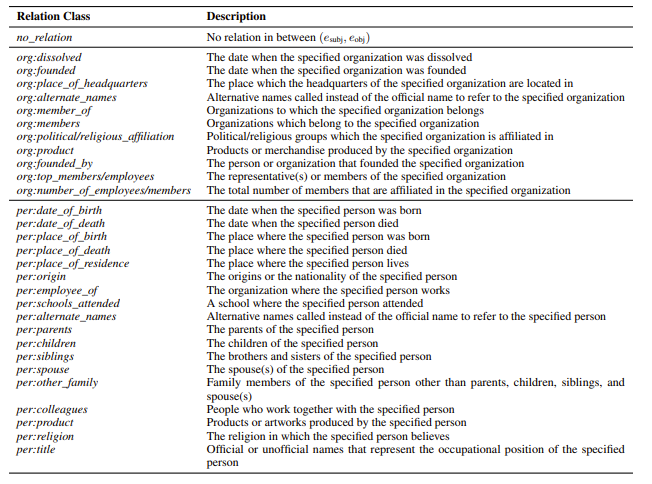

In [5]:
print(len(train_df['label'].unique()))
label_list = sorted(list(train_df['label'].unique()))
for label in label_list:
    label_rows = train_df[train_df['label'] == label]
    print(f"Label: {label}")
    
    for idx, row in label_rows.head(5).iterrows():  
        print(row['sentence'])
        print(row['subject_entity'], row['object_entity'])
    print("\n") 

30
Label: no_relation
〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다.
비틀즈 조지 해리슨
호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으로 재탄생한다.
민주평화당 대안신당
1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8번으로 배정되었다.
요미우리 자이언츠 1967
그에 따라 나폴리와 계약을 연장한 마라도나는 1989년 팀을 UEFA컵 정상으로 인도했으며 이듬해에는 유럽 챔피언 AC 밀란을 상대로 승리를 거두고 다시 한 번 세리에A에서 정상에 등극했다.
AC 밀란 1989
조토 디 본도네, 마사초, 피에로 델라 프란체스카, 도메니코 기를란다요, 페루지노, 미켈란젤로, 라파엘로, 보티첼리, 레오나르도 다빈치, 티치아노 등으로 대표되는 이탈리아 르네상스 회화는 당대와 그 이후의 시기 유럽 전체에 영향을 주었다.
미켈란젤로 르네상스


Label: org:alternate_names
: 유엔, 유럽 의회, 북대서양 조약 기구 (NATO), 국제이주기구, 세계 보건 기구 (WHO), 지중해 연합, 이슬람 협력 기구, 유럽 안보 협력 기구, 국제 통화 기금, 세계무역기구 그리고 프랑코포니.
북대서양 조약 기구 NATO
이 대회는 1960년에 출범하여 매년 개최되어왔으며 유럽 축구 연맹(UEFA)과 남미 축구 연맹(CONMEBOL)이 공동으로 주관했다.
유럽 축구 연맹 UEFA
미국 정부는 1942년 2월 24일 전 세계의 청취자를 대상으로 태평양 전쟁의 전쟁상황을 알리기 위한 방송인 미국의 소리(VOA, Voice of America)를 개국하였다.
미국의 소리 Voice of America
이어 “향후 우리 창업벤처기업들이 세계가 주목하는 줌(Zoom)과 페이스북(Facebook)과 같은 글로벌 플랫폼 기업으로 성장하도록 지원하고 대한민국이 ‘벤처 4대강국’으로 자리매김하도록 최선을 다할 계획”이라고 밝혔다.
Faceboo

org_founded, place_of_headquarters 같은거 보면, 어느 위치에 있는 1984년이 어느 위치에 있는 롯데 자이언츠와 연관인지, 그 포지션을 집어주는 것도 중요할 수 있을 것 같음

org_member_of, org_members 좀 뜯어봐야 할듯. 얘는 내가 봐도 못풀겠는데.

place_of_headquarters, political, obj_product도 좀 어렵다. 

residence는 너무 당연하고, 그래서 맞추기 더 어려움 -> 이런거는 나중에 어떤 sub랑 어떤 obj의 조건에서 어떤 class만 나올 수 있냐와 연관지어서, residence의 obj는 보통 국가/위치 뭐 그런걸테니깐, 그런게 나오면 residence를 포함한, 이 조합이 가능한 것들에 대해 더욱 그렇게 예측하도록 걔네 logits을 올려주는 식으로.

top_member에 박찬호는 이게 맞나? 그럼 비틀즈의 조지 해리슨은?

other_family는 거의 문제가 틀린것같은데. 

colleagues 같은건 순서 바꿔도 되겠네. 이런 경우가 또 뭐가 있을까? - children <->parents, member_of <-> members, other_family, siblings, spouse

date_of_birth에는 오타가 있네. 오타도 있고(1) 파싱이 잘못된 경우(2)도 있음

siblings를 비롯해서 person/person 간의 가족 관계  맞춰야 할 때, val_set에서 만약 per/per라면 어떻게 예측했는지 직접 logit 확인해보는 것도.

----
1. 어떤 것들은 매우 간단하게 augmentation이 가능해보임. 단, ENT의 이름을 바꿔줄 수 있으면 그렇게 하는게 좋을수도?

2. 어떤 단어/문맥으로 인해 해당 sub-obj 관계가 딱 그 label의 클래스로 분류되는지 정성평가 필요해보임(Ex. origin과 birth는 어떻게 분류될까? '탄생' -> birth쪽으로 분류). 역시, 부족한 것들은 augmentation.

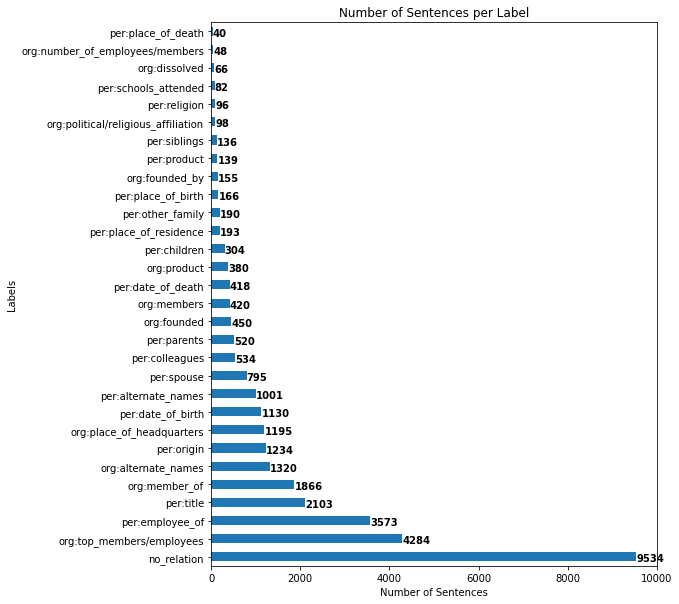

In [6]:
label_counts = train_df['label'].value_counts()

plt.figure(figsize=(8, 10))
ax = label_counts.plot(kind='barh')
plt.xlabel('Number of Sentences')
plt.ylabel('Labels')
plt.title('Number of Sentences per Label')

for i, v in enumerate(label_counts):
    ax.text(v + 3, i - 0.25, str(v), color='black', fontweight='bold')

plt.show()

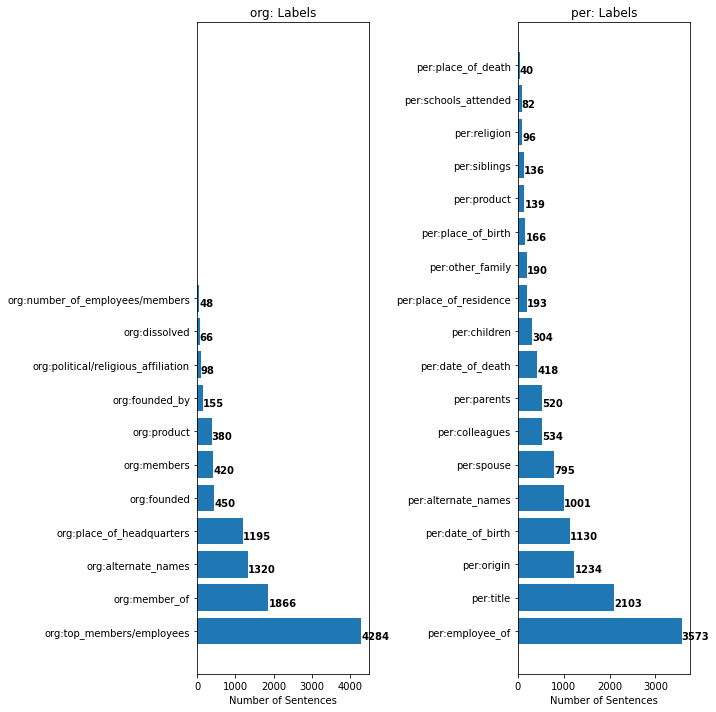

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter org and sub labels
org_labels = train_df[train_df['label'].str.startswith('org:')]
sub_labels = train_df[train_df['label'].str.startswith('per:')]

# Count occurrences
org_label_counts = org_labels['label'].value_counts()
sub_label_counts = sub_labels['label'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot org labels
ax1.barh(org_label_counts.index, org_label_counts.values)
ax1.set_title('org: Labels')
ax1.set_xlabel('Number of Sentences')

# Add actual count numbers for org labels
for i, v in enumerate(org_label_counts):
    ax1.text(v + 3, i - 0.25, str(v), color='black', fontweight='bold')

# Plot sub labels
ax2.barh(sub_label_counts.index, sub_label_counts.values)
ax2.set_title('per: Labels')
ax2.set_xlabel('Number of Sentences')

# Add actual count numbers for sub labels
for i, v in enumerate(sub_label_counts):
    ax2.text(v + 3, i - 0.25, str(v), color='black', fontweight='bold')

# Set y-axis limits to be the same for both plots
ax1.set_ylim(ax2.get_ylim())

plt.tight_layout()
plt.show()


## Object (and Subject) Label Possibilities

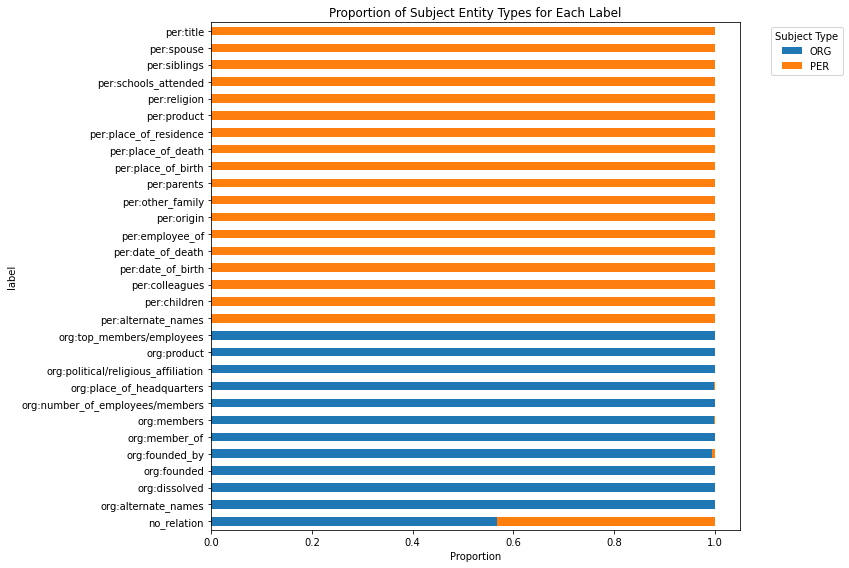

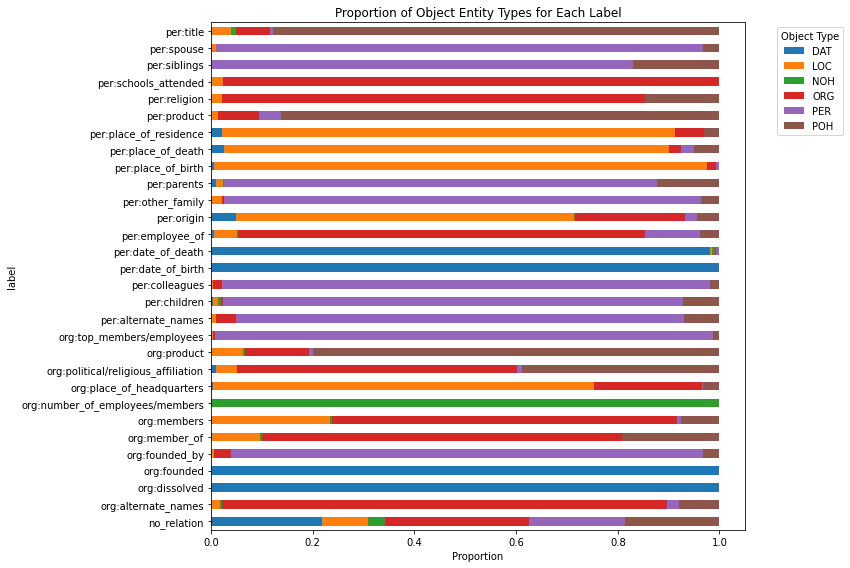

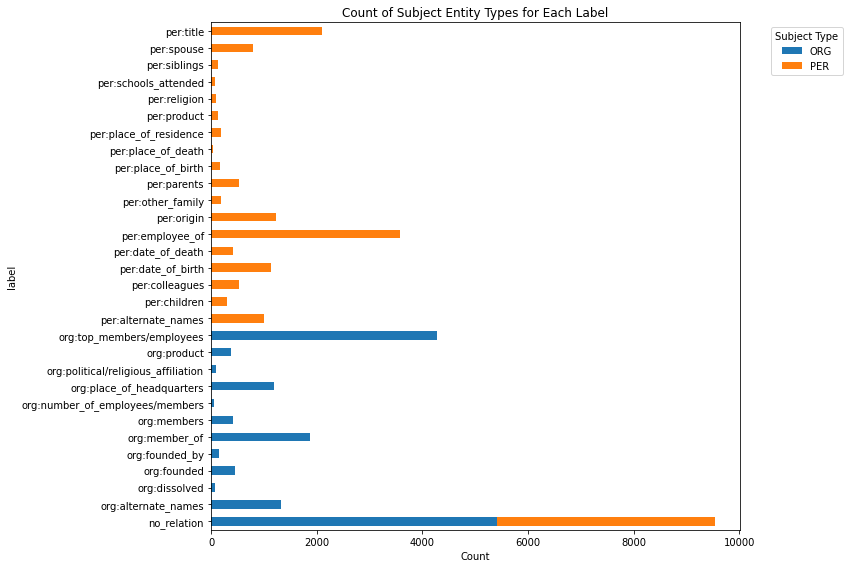

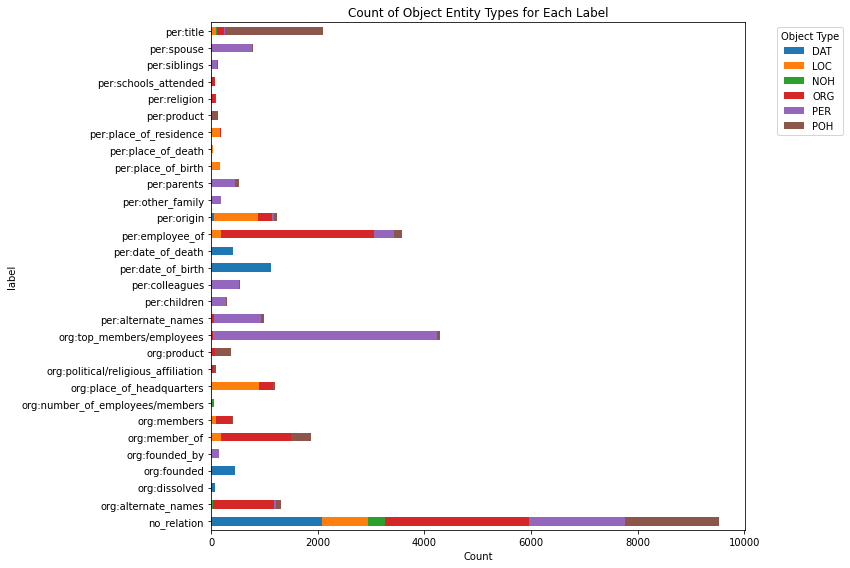

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate the count of subject and object entity types for each label
subject_label_counts_actual = pd.crosstab(train_df['label'], train_df['subject_type'])
object_label_counts_actual = pd.crosstab(train_df['label'], train_df['object_type'])

# Calculate the proportion of subject and object entity types for each label
subject_label_counts = subject_label_counts_actual.div(subject_label_counts_actual.sum(axis=1), axis=0)
object_label_counts = object_label_counts_actual.div(object_label_counts_actual.sum(axis=1), axis=0)

# Plot subject entity type proportions
fig, ax = plt.subplots(figsize=(12, 8))
subject_label_counts.plot(kind='barh', stacked=True, ax=ax)
ax.set_title('Proportion of Subject Entity Types for Each Label')
ax.set_xlabel('Proportion')
ax.legend(title='Subject Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot object entity type proportions
fig, ax = plt.subplots(figsize=(12, 8))
object_label_counts.plot(kind='barh', stacked=True, ax=ax)
ax.set_title('Proportion of Object Entity Types for Each Label')
ax.set_xlabel('Proportion')
ax.legend(title='Object Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot subject entity type counts
fig, ax = plt.subplots(figsize=(12, 8))
subject_label_counts_actual.plot(kind='barh', stacked=True, ax=ax)
ax.set_title('Count of Subject Entity Types for Each Label')
ax.set_xlabel('Count')
ax.legend(title='Subject Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot object entity type counts
fig, ax = plt.subplots(figsize=(12, 8))
object_label_counts_actual.plot(kind='barh', stacked=True, ax=ax)
ax.set_title('Count of Object Entity Types for Each Label')
ax.set_xlabel('Count')
ax.legend(title='Object Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [26]:
object_type_counts_per_label = train_df.groupby('label')['object_type'].value_counts()
pd.set_option('display.max_rows', 200)

object_type_counts_per_label

label                                object_type
no_relation                          ORG            2699
                                     DAT            2087
                                     PER            1800
                                     POH            1780
                                     LOC             858
                                     NOH             310
org:alternate_names                  ORG            1154
                                     POH             106
                                     PER              31
                                     LOC              23
                                     NOH               5
                                     DAT               1
org:dissolved                        DAT              66
org:founded                          DAT             450
org:founded_by                       PER             144
                                     ORG               5
                                     PO

In [10]:
subject_type_counts_per_label = train_df.groupby('label')['subject_type'].value_counts()
pd.set_option('display.max_rows', 200)

subject_type_counts_per_label

label                                subject_type
no_relation                          ORG             5406
                                     PER             4128
org:alternate_names                  ORG             1320
org:dissolved                        ORG               66
org:founded                          ORG              450
org:founded_by                       ORG              154
                                     PER                1
org:member_of                        ORG             1866
org:members                          ORG              419
                                     PER                1
org:number_of_employees/members      ORG               48
org:place_of_headquarters            ORG             1194
                                     PER                1
org:political/religious_affiliation  ORG               98
org:product                          ORG              380
org:top_members/employees            ORG             4283
                      

### 주절주절

title에 loc이 왜 들어가지? 확인해보니까 '~의 누구누구'를 LOC으로 분류를... 이건 틀린거 아닌가,, spouse, product도 마찬가지인듯
religion는 loc이 맞긴 한데, religion이 틀림.
per:place_of_~는 진짜 무조건 뒤에 LOC아님? 보니까 LOC인데 LOC이라고 안 썼거나, 애초에 place_of_~ 클래스가 아님. 근데, LOC가 아니긴 한데, 보면 그렇게 붙어있는경우들이 종종 있어서 고치기가 좀 꺼려짐. 나라이름 같은거, 특히. LOC일때도 있고 ORG일 때도 있고 POH일 때도 있음. 근데 또 DAT이 붙는건 납득이 안됨. 잘 구분해서 학습하게 할지 고쳐줄지 정해야할듯
per:parents도, ~시대가 붙어있는 경우에 DAT이 올 때가 있음. 오류라고 봐야겠지..? LOC도 마찬가지. 남연'군'이라서 LOC라고 붙히셨습니까? NOH도 확실히 오류
other family도 title과 같은 이유로 LOC이 붙는다.
per:origin은 origin혹은 nationality니깐 LOC이나 ORG나 잘하면 POH까지만 허용될 것 같은데? DAT는 분류가 잘못된 것 같고, PER는 라벨링이 잘못된것같다
per:employee_of : 샘플 183, 392, 656, ... 등등 employee_of의 순서가 바뀐 샘플이 너무 많다. 의도한건가? 아님 이게 싹다 잘못된 데이터인건가? 이상한게, 다른 분류는 안 그런데 PER 분류에 대해서만 이렇다.
per:date_of_death의 오류 분류들.
colleagues : ORG가 왜있나 봤더니, PER인데 잘못 들어간듯. 그리고 ORG의 예시는 전부 거의 유시민/노무현. PER로 고쳐주는 것도 고쳐주는 건데, 어떤 label에 대한 sample이 모두 같은 대상으로 이루어져있다면 거기에 오버피팅 될 수도 있을 것 같음. 데이터 반은 mask로 sub/obj 가리든지 해야할 것 같다.
children 오류
alternate_names에도 오류..

### 이건, 각 label당 object type 뽑아보고, 갯수가 너무 작은 것은 의심해보고 확인해보고 빼는 것으로.
------

납득 되는 것과 안 되는 것으로 구분을 해야함.
Ex. spouse인데 LOC으로 분류를 했다? -> 당연히 배우자는 LOC일 수 없지만, '~의 누구' 일 때 LOC로 분류가 되더라 -> test 데이터에서도 그렇게 분류된 것이 있으니 함부로 건들지 않는게 좋을 수도 있다.
vs.
EX. 315 샘플은 아예 라벨링도 잘못되고, 분류도 잘못됨 -> 이유를 추론할 수 없는, 단순 오류일 경우 수정하는게 맞을듯

### About Overfitting
어떤 class에 대해서 Sub가 단어 x, Obj가 단어 y로 데이터가 고정되는 경우가 있음. 이런 경우를 카운팅해서 임의로 좀 바꿔주면 좋을 것 같다. 특히 적은 수의 클래스에 대해 이게 좀 심한 것 같음. 

### About Augmentation
우리가 임의로 만들어 줄 수 있는 클래스가 무엇인지 생각해보자.
Ex. date_of_birth : sub를 이름 생성기로 사람이름으로 바꿔주고,obj를 마음대로 날짜를 만들어주면 된다. 그리고 안에 문장은 적당히 EDA or AEDA로 진짜 살짝만 틀어주면 좋을 것 같음.
Ex. num_of_~들 : 항상 obj로 숫자가 오니깐, 수를 바꿔주고 sub를 obj면 다른 obj, per면 다른 per로 바꿔주고 안에 문장은 적당히 EDA or AEDA 하면 좋을 것 같음

Ex. date_of_birth <-> date_of_death : (OO년 00월 00일 ~ 00년 00월 00일)에 obj가 붙어있는 문장들이 있음. 그 경우에, 서로 바꾸면 augmentation 가능할 것 같다.

### About Bad labels
가끔 보면 관계가 뒤바뀌어서 라벨링 된 것들이 있다. 그런 샘플들이 많은 class의 경우, 제대로 라벨링을 바꿔주거나, 라벨 스무딩이 좀 도움이 될 수 있지 않을까...?

### About NOH label

실제 숫자에 NOH가 잘 붙어있는 경우가 아닌, '제 0사단 / 제 0 리그' 등과 같이, NOH 가 아닌데도 숫자가 되어있는 경우가 있음. 이런 경우에 Rule-based로 NOH -> ORG(POH)로 바꿔주면 좋겠다. train/test 둘 다

### About DAT label

괜히 당 태종, 청 예종 뭐 이런 거는 사람으로 쓰였을 때도 DAT으로 구분 되는 경우가 많음. 이런 경우 Rule-based로 바꿔줄까..?

### About ORG label

나라는 ORG로 보통 분류가 많이됨. nationality 개념이 같이 들어가서 그게 더 자연스러운 것 같다. 혼동하지 말자. 나라는 ORG!

### SUB : ORG일 때

org:alternate_names : 사실상 모두 올 수 있음. aug해서 데이터를 맞춰줬으면 맞춰줬지, 불가능한 label은 없는 것으로 보임

org:dissolved : 무조건 DAT

org:founded  : 무조건 DAT

org:founded_by : 정의 상 PER, ORG만 가능. LOC이랑 POH를 각각 ORG나 PER에 병합시키는 건 어떨까(확실X)

org:member_of : subject org가 object org에 속하는. 그러므로 당연히 ORG와 POH와 LOC까지는 가능할 것(갯수로 봤을 때도 그러함). NOH, DAT, PER는 빼야하지 않을까?

org:members : object org가 subjectorg에 속하는. 마찬가지로 ORG와 POH와 LOC까지 가능해야 함. + member_of와 members는 교차하면 서로 augmentation 가능

org:number_of_employees/members 무조건 NOH

org:place_of_headquarters : subject org의 headquarter가 있는 곳. 정의 상 LOC(ORG), POH만 가능. 근데, DAT가 붙은 경우를 보니 '청나라' 같이 시대로도 인식될 수 있는 것. 청만 괜찮고 나머지는 다 오류 분류

org:political/religious_affiliation : subject org가 표방하는 정치/종교 집단이나 색깔. 정의 상 ORG, POH가 가능. LOC는 바티칸의 경우 반대로 잘못 라벨링 된 것 같고, 나머지는 이슬람이 LOC로 들어감. 얘는 냅둬야할듯

org:product : 정의 상 POH, ORG(자회사 같은거)가 가능할 것 같음. 근데 LOC가 은근 많아서 보니깐 아파트 같은건 LOC로 들어가는 것 같다. PER은 가상 캐릭터를 만들어 냈을 때 일관적으로 붙이는 것 같고... NOH는 잘못 붙은 것 같음

org:top_members/employees : 정의상 PER, POH, ORG(대표자'들')가 되어야 할 것 같음. LOC는 보니까 나라나 도시 같음. 근데 호찌민이 너무 많아서 좀 임의의 나라-도시 쌍으로 바꿔주고 싶음. NOH는 오류인듯



### SUB : PER일 때

per:alternate_names : 정의 상 PER, POH이 맞음. ORG도 per가 여러 사람일 때 가능할듯. LOC, NOH는 여기에서는 잘못된 것 같다. 들어갈 수 없겠지..?

per:children : 이건 진짜 PER, POH(딸 OO, 아들 XX)만 가능할 것 같은데..? 다른 거는 다 오류

per:colleagues : 정의 상 PER, ORG, POH만 가능할 듯. 근데, ORG 가능하긴 한데, ORG가 다 노무현임. 최소한 PER로 고쳐주거나, 다른 사람 이름으로 바꿔야 오버피팅 안날듯 (Ex. Per는 유시민에 ORG는 노무현이어야만 colleagues가 되게 오버피팅 날수도) 다른 거는 다 오류

per:date_of_birth : 정의 상 DAT만 가능. 나머지는 오류인듯 하면서도, NOH는 남겨둘까 싶기도 함. Test에서도 똑같은 이유로 NOH로 분리되었을 수도 있으니.

per:date_of_death : 정의 상 DAT만 가능. 위와 같은 이유로 NOH만 남겨둘까 싶음. 나머지는 오류. LOC는 place of death임.

per:employee_of : sub가 일하는 곳, 모시는 사람. 이런 것인듯. 그렇게 보면 ORG, PER, LOC, POH 다 됨. 근데 보니까 똑같이 PER-PER의 경우, 주종이 바뀌어 있는 라벨이 좀 많은 것 같다. DAT, LOH(권정열-10cm)는 오류.

per:origin : 정의 상 LOC, ORG(나라)가 가장 잘 어울림. DAT가 많은 이유는, 앞의 DAT의 특성상, 고려나 이런 애들이 DAT으로 분류가 되어서. 다 바꾸기엔, 모든 시대를 나타내는 나라(청, 명, 조선, 고려, 고구려 등)를 전부 LOC이나 ORG로 바꿔야해서.. 이건 그냥 냅두는게 낫겠다. 그리고 읽어보니 POH도 가능할듯. 어디어디(무슨 당, 무슨 혈족) 출신. 이런것는 다 POH로 들어가네. 나머지는 다 오류

per:other_family : PER, POH가 가장 자연스러움. LOC는 origin의 예시에 가깝지 않나..? 좀 거슬림. ORG는 오류. 근데 swap 가능

per:parents : PER, POH가 가장 자연스러움. LOC는 PER/POH로 바꿔줘도 될 것 같음. DAT/NOH도 마찬가지

per:place_of_birth : LOC, ORG(나라)가 제일 잘 어울림. 근데, origin하고 좀 헷갈린다. '태어났다'는 문맥이 존재해야 하나봄. DAT, PER은 오류.

per:place_of_death : LOC, ORG가 제일 잘 어울림. 근데 보니까, origin과 달리, place_of_~는 ORG로 분류되는 게 훨씬 적다? ORG 관점이 아니라 LOC 관점이라 그런가? 출생지니깐? 그럼 ORG도 없애야 하나 고민이 된다. 나머지는 다 LOC로 고쳐줘야 하는 라벨

per:place_of_residence : 같은 이유로 LOC이 제일 잘 어울린다. 근데 ORG, POH, DAT 데이터가 다 늘었다. 얘네는 그대로 써야할지 고민이 된다.

per:product : 오히려 다 될 것 같기도 하고...? 얘는 데이터가 골고루 없어서 걱정. org에서 적당히 바꾸써 좀 가져올까? 물론 org NOH는 잘못 된 데이터이긴 함.

per:religion : ORG, POH(like 무신론, 이신론)가 제일 자연스러움. LOH는 오류가 난.

per:schools_attended: ORG, POH가 제일 자연스러움. LOC가 있는데, ORG에 더 가깝고, 쓴다 하더라도 중복이라 좀 고쳐줘야 할듯.

per:siblings : PER, POH만 가능.

per.spouse : PER, POH만 가능. LOC, DAT, ORG는 오류.

per:title : 직명같은거? POH만 가능할 것 같은데 정의상, 근데 뭐가 되게 많다. 일단 ORG는 직급 앞에 해당 조직이 오면 ORG로 분류가 되는듯. 그럴듯 하다. 라벨 고치기에는 부담. LOC도 같은이유에서 부담. PER는 진짜 직업같은거. alternate_names랑 같은 이유로 오나, 직업적인 면이 커서 거기로 안가고 여기로 온듯. DAT은 오류.

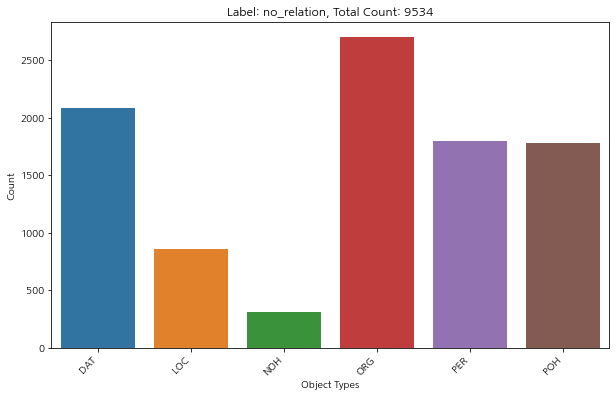

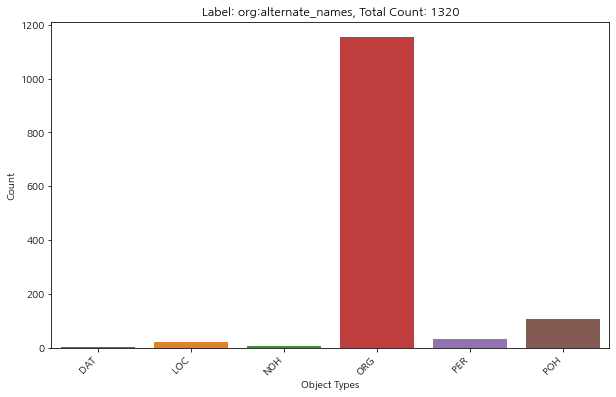

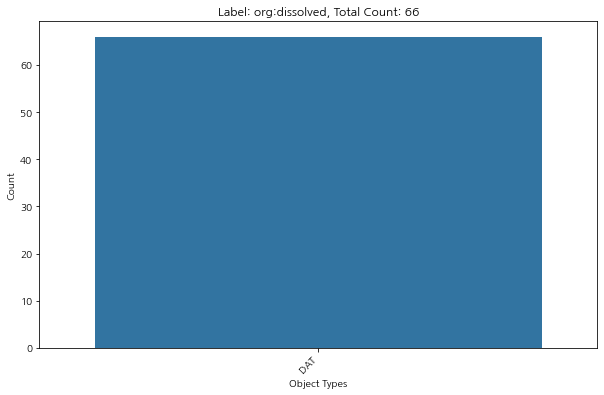

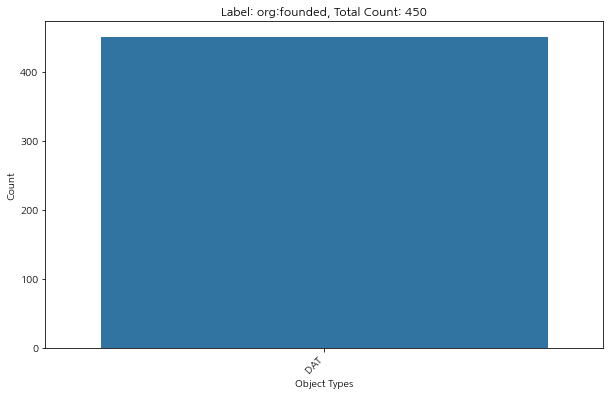

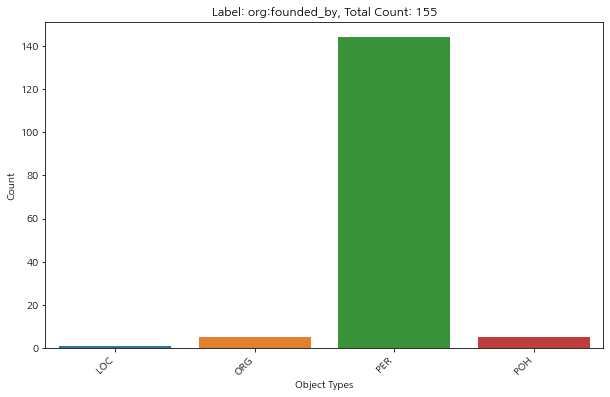

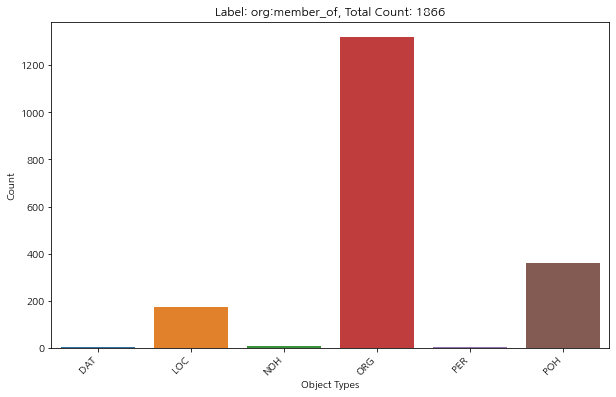

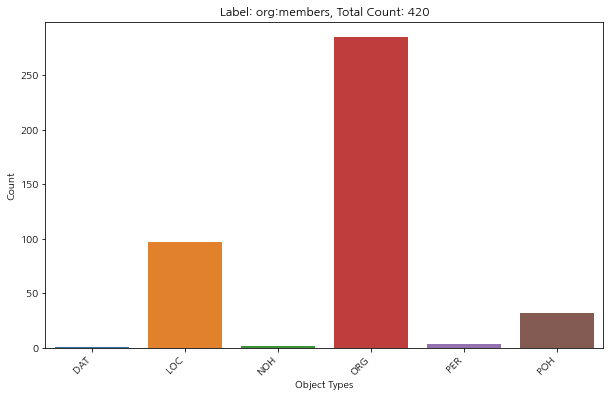

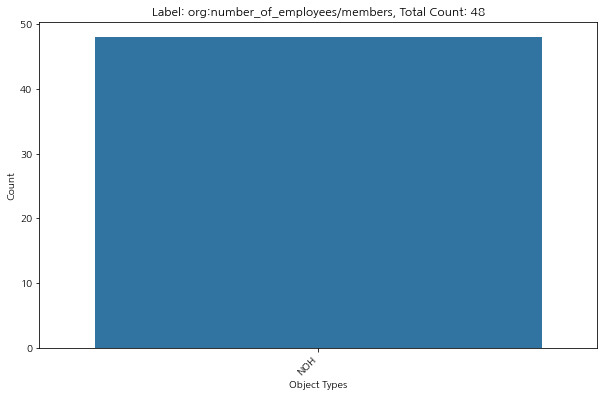

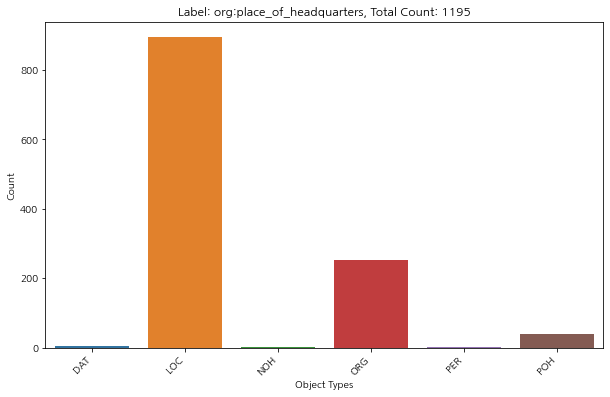

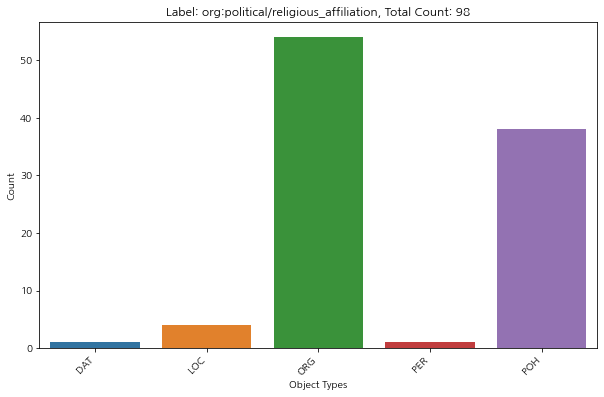

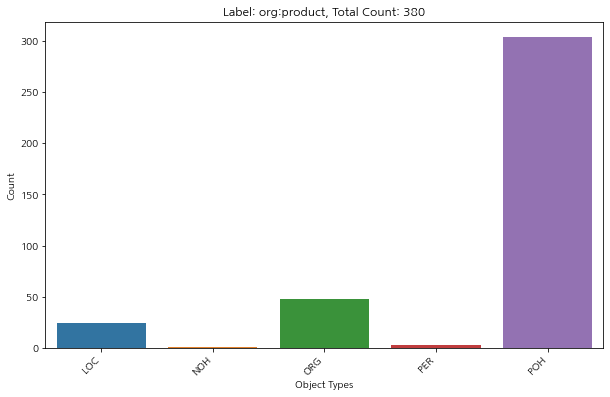

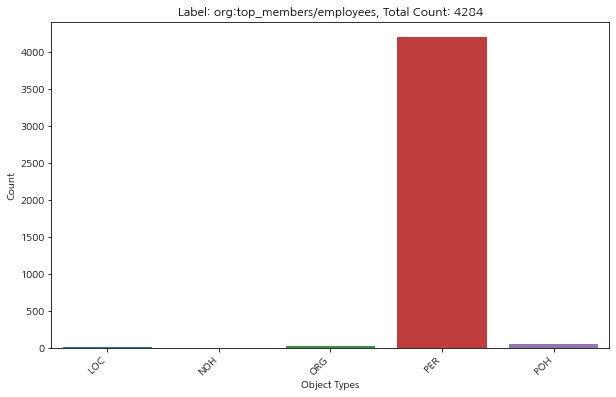

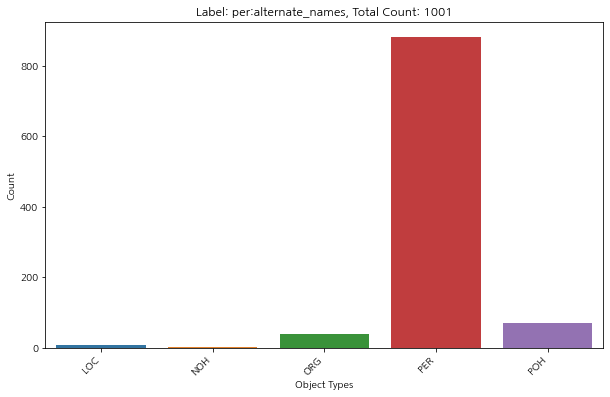

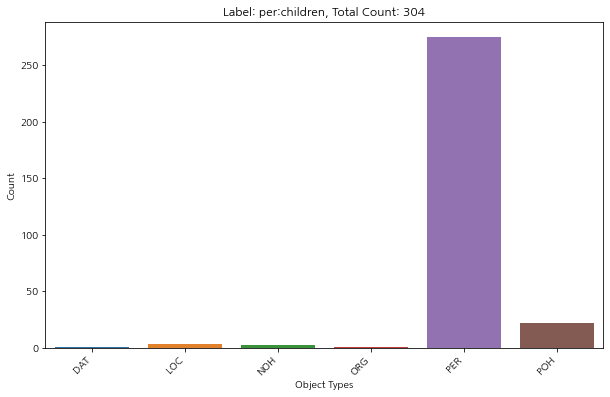

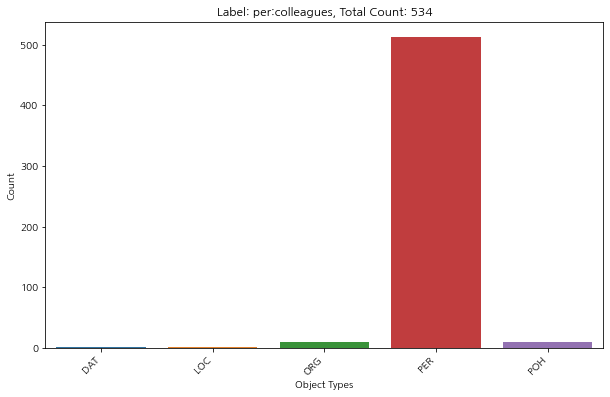

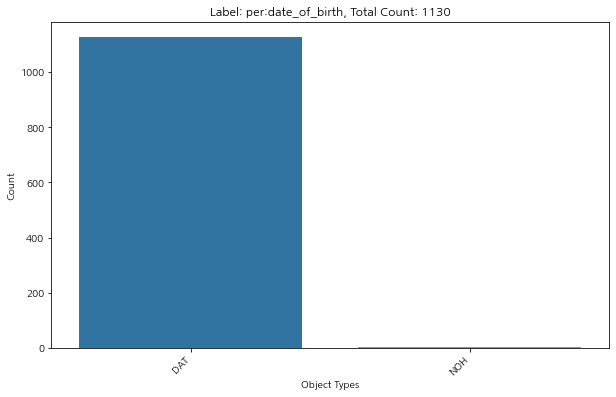

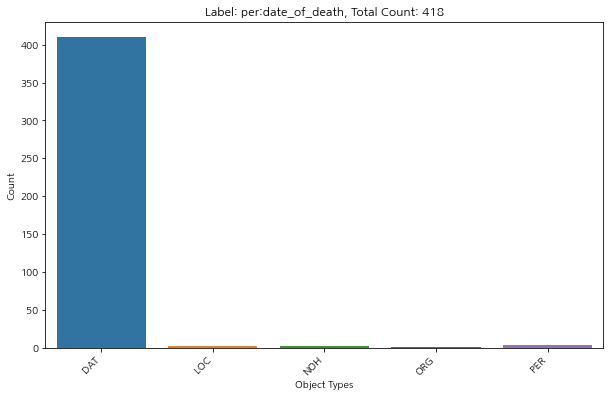

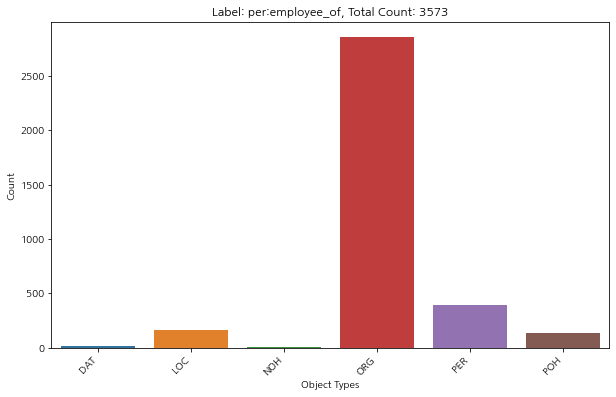

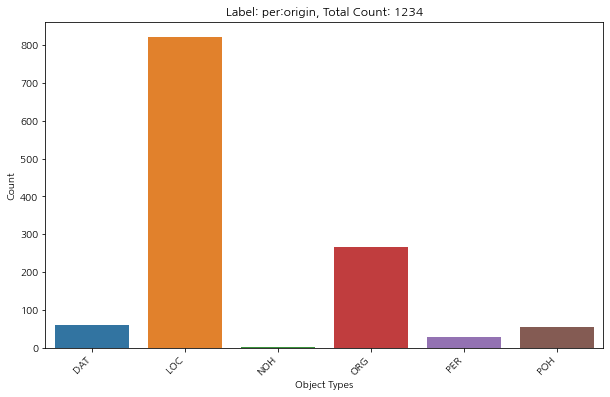

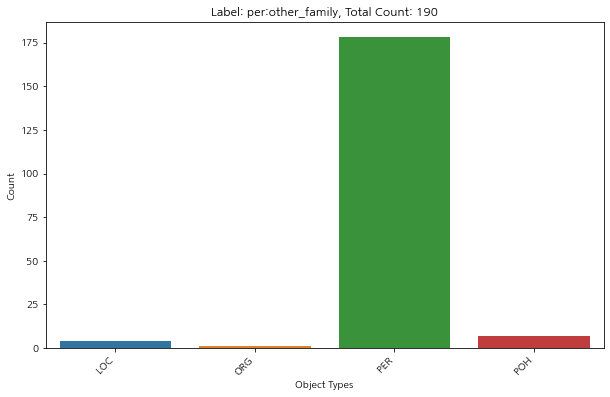

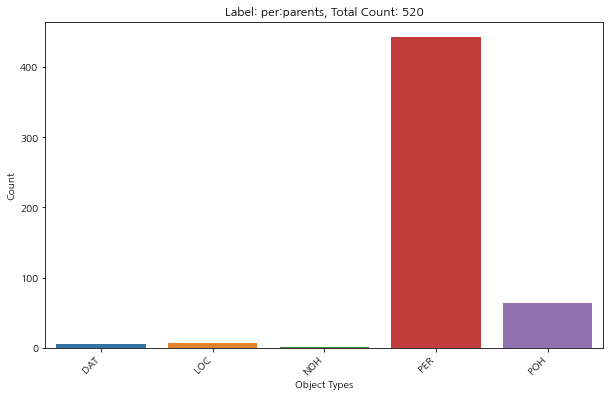

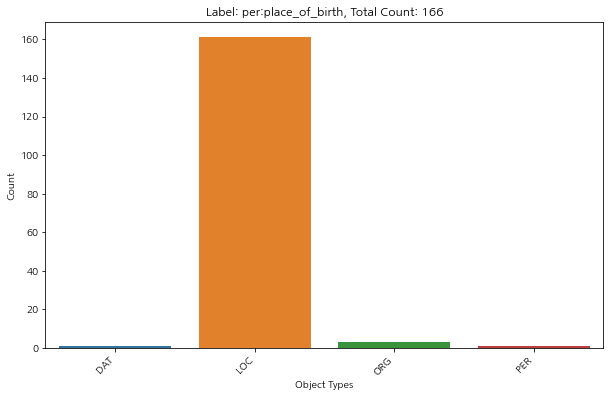

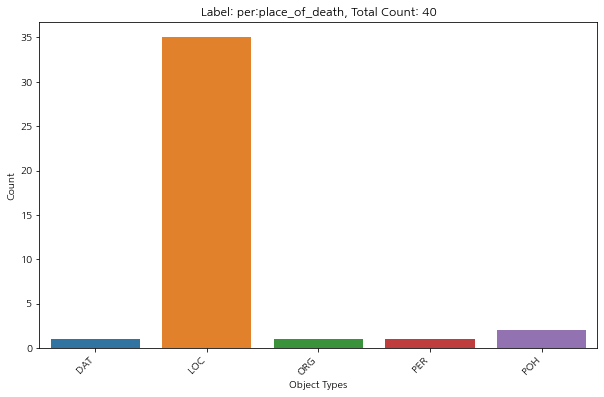

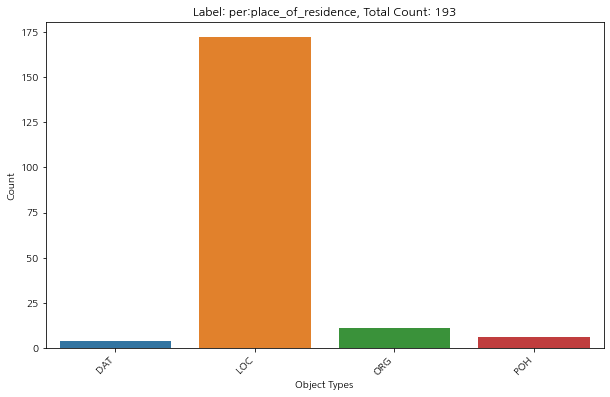

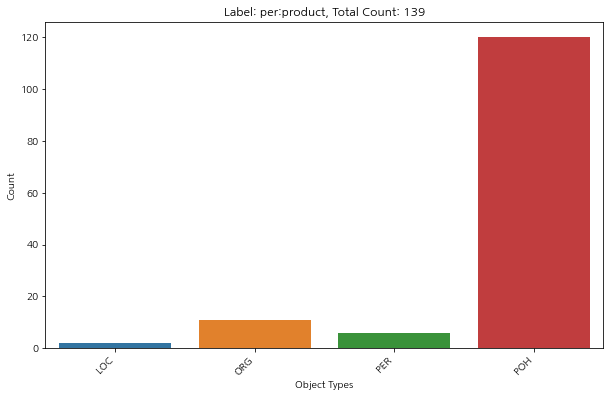

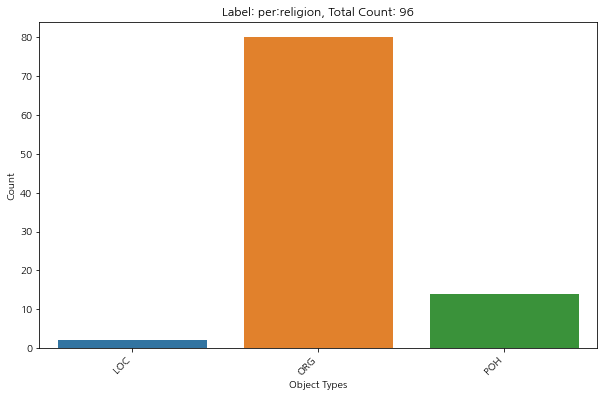

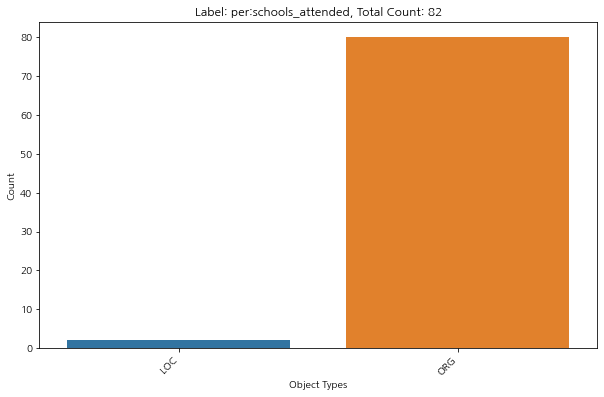

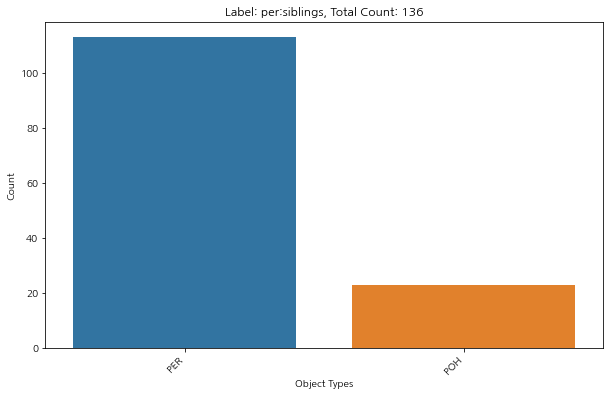

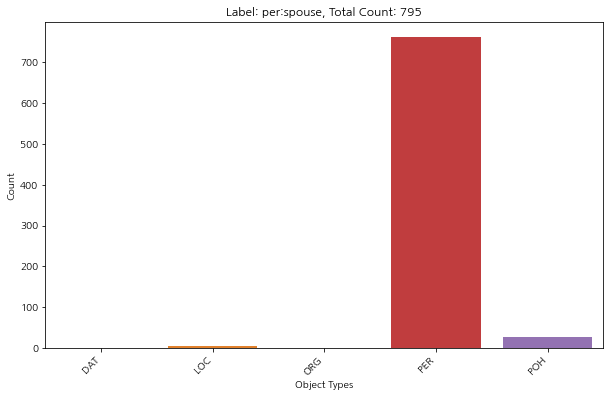

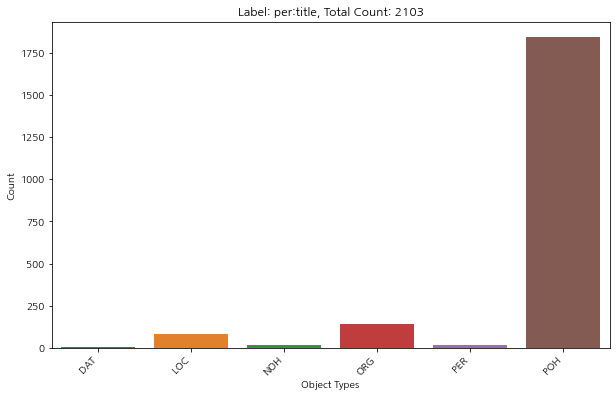

In [23]:
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

# Get total counts for each label
total_label_counts = train_df['label'].value_counts()

# Group by label and object_type and count the occurrences
result = train_df.groupby(['label', 'object_type']).size().reset_index(name='count')

# Iterate over each unique label in the result DataFrame
for label in result['label'].unique():
    # Filter the DataFrame for the current label
    label_data = result[result['label'] == label].reset_index(drop=True)
    label_count = total_label_counts[label]

    # Create a bar plot for the current label
    plt.figure(figsize=(10, 6))
    sns.barplot(x='object_type', y='count', data=label_data)
    plt.title(f"Label: {label}, Total Count: {label_count}")
    plt.xlabel("Object Types")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.show()


## Troubleshoot Entity Overfitting

In [11]:
# Group the DataFrame by 'label' and 'subject_entity', and count the occurrences
subject_entity_counts_per_label = train_df.groupby(['label', 'subject_entity']).size().reset_index(name='count')

# Filter the subject entities that were used more than twice
subject_entities_used_more_than_twice = subject_entity_counts_per_label[subject_entity_counts_per_label['count'] > 2]

# Display the results
print(subject_entities_used_more_than_twice)


             label subject_entity  count
2      no_relation           11번가      3
5      no_relation        4.25체육단      5
11     no_relation          AB인베브      3
12     no_relation          AC 밀란     11
14     no_relation        AFC 아약스      6
...            ...            ...    ...
17231    per:title          헤로도토스      4
17244    per:title            홍남기      4
17250    per:title            홍정오      3
17262    per:title            황인범      3
17263    per:title            황인철      4

[2444 rows x 3 columns]


In [12]:
# Group the DataFrame by 'label', 'subject_entity', and 'object_entity', and count the occurrences
entity_pairs_counts_per_label = train_df.groupby(['label', 'subject_entity', 'object_entity']).size().reset_index(name='count')

# Filter the entity pairs that were used more than twice
entity_pairs_used_more_than_twice = entity_pairs_counts_per_label[entity_pairs_counts_per_label['count'] > 2]

# Display the results
print(entity_pairs_used_more_than_twice)


             label subject_entity object_entity  count
2      no_relation           11번가         SK텔레콤      3
15     no_relation          AB인베브           벨기에      3
22     no_relation          AC 밀란          2007      4
62     no_relation        CJ프레시웨이        CJ제일제당      6
70     no_relation         DB금융투자           12월      6
...            ...            ...           ...    ...
19865    per:title            한혜연        스타일리스트      6
19879    per:title          헤로도토스           역사가      4
19900    per:title            홍정오           유튜버      3
19913    per:title            황인범      공격형 미드필더      3
19914    per:title            황인철           변호사      4

[2193 rows x 4 columns]


In [13]:
# Group the DataFrame by 'label', 'subject_entity', and 'object_entity', and count the occurrences
entity_pairs_counts_per_label = train_df.groupby(['label', 'subject_entity', 'object_entity']).size().reset_index(name='count')

# Filter the entity pairs that were used more than twice
entity_pairs_used_more_than_twice = entity_pairs_counts_per_label[entity_pairs_counts_per_label['count'] > 2]

# Count the occurrences for each label
label_counts = train_df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'label_count']

# Merge the label counts with the entity pairs used more than twice
result = entity_pairs_used_more_than_twice.merge(label_counts, on='label')

# Display the results
print(result)


            label subject_entity object_entity  count  label_count
0     no_relation           11번가         SK텔레콤      3         9534
1     no_relation          AB인베브           벨기에      3         9534
2     no_relation          AC 밀란          2007      4         9534
3     no_relation        CJ프레시웨이        CJ제일제당      6         9534
4     no_relation         DB금융투자           12월      6         9534
...           ...            ...           ...    ...          ...
2188    per:title            한혜연        스타일리스트      6         2103
2189    per:title          헤로도토스           역사가      4         2103
2190    per:title            홍정오           유튜버      3         2103
2191    per:title            황인범      공격형 미드필더      3         2103
2192    per:title            황인철           변호사      4         2103

[2193 rows x 5 columns]


In [14]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [15]:
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]

['Nanum Brush Script',
 'NanumGothic',
 'NanumSquareRound',
 'NanumMyeongjo Eco',
 'NanumMyeongjo',
 'NanumGothicCoding',
 'NanumGothic Eco',
 'NanumBarunGothic',
 'NanumSquare',
 'NanumGothic',
 'NanumSquare',
 'NanumGothic Eco',
 'NanumSquareRound',
 'NanumMyeongjo Eco',
 'NanumGothic',
 'Nanum Pen Script',
 'NanumBarunGothic',
 'NanumSquare',
 'NanumMyeongjo Eco',
 'NanumGothic',
 'NanumMyeongjo',
 'NanumSquareRound',
 'NanumBarunpen',
 'NanumSquareRound',
 'NanumBarunGothic',
 'NanumGothicCoding',
 'NanumBarunpen',
 'NanumGothic Eco',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumBarunGothic']

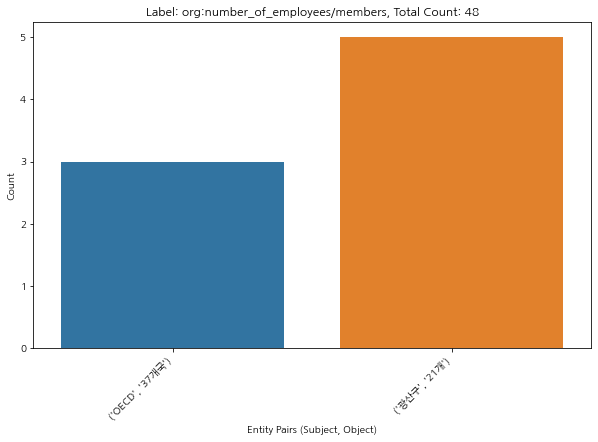

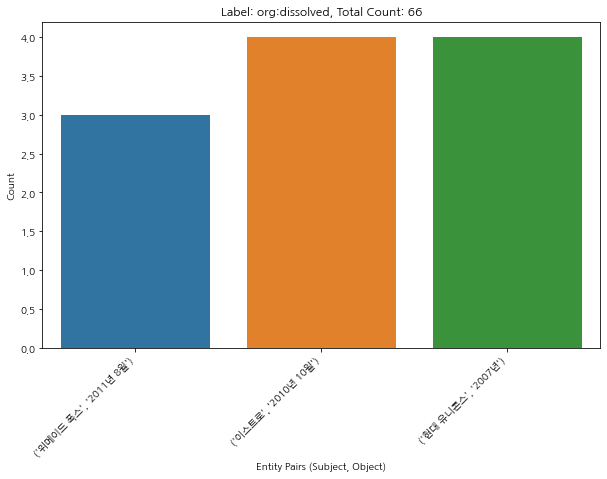

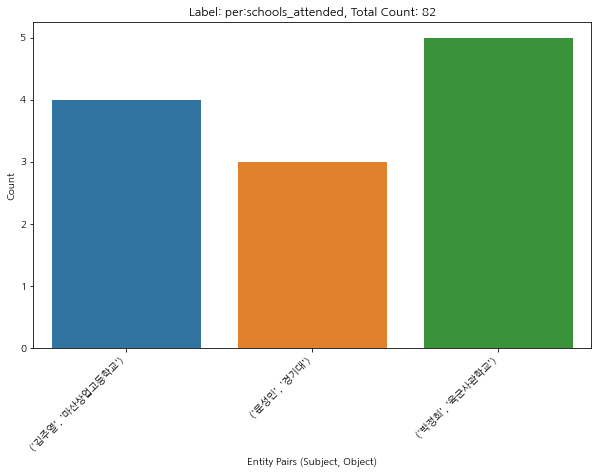

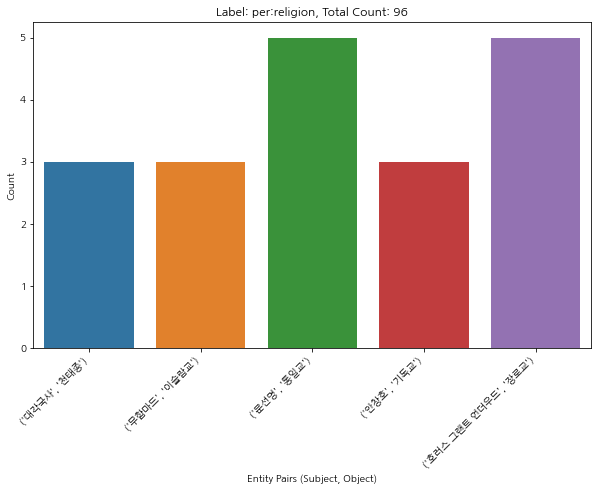

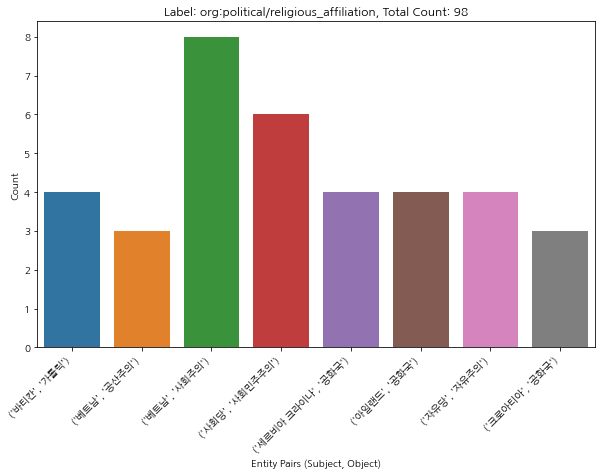

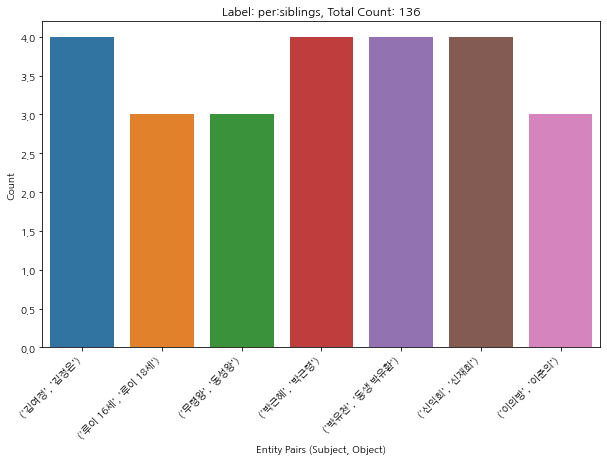

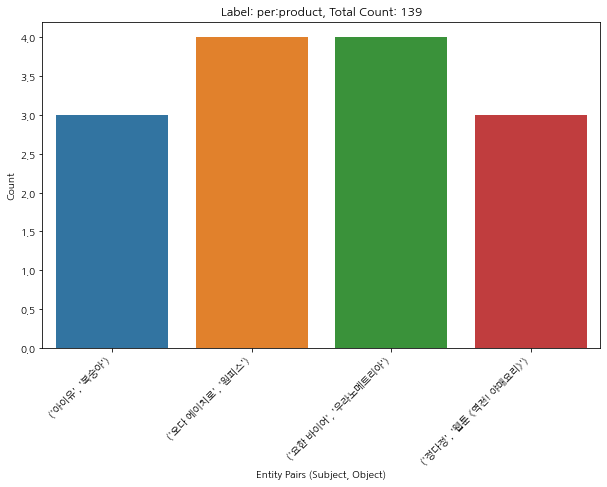

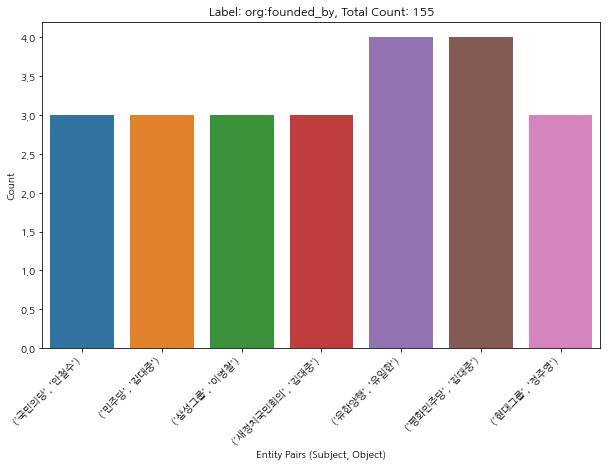

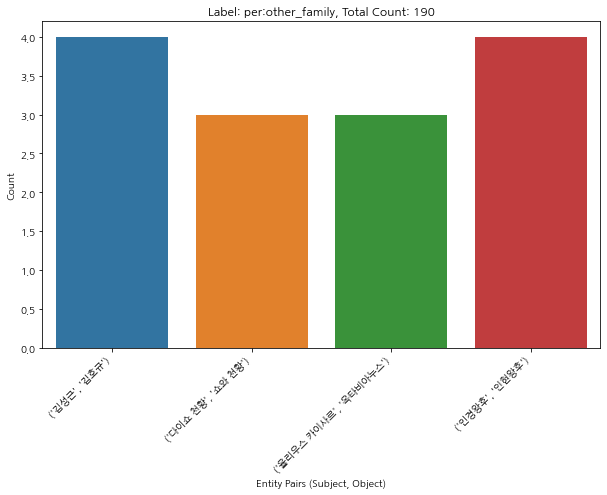

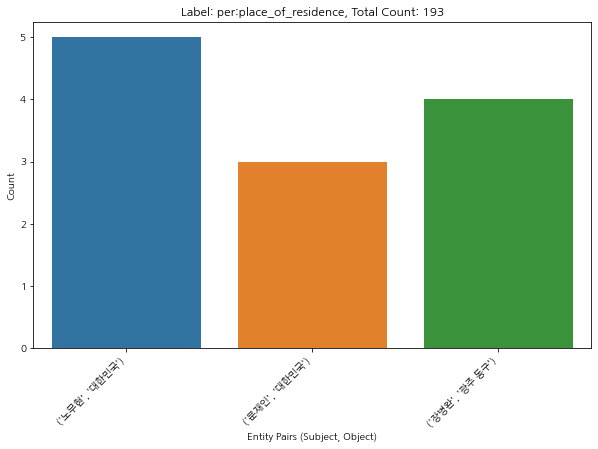

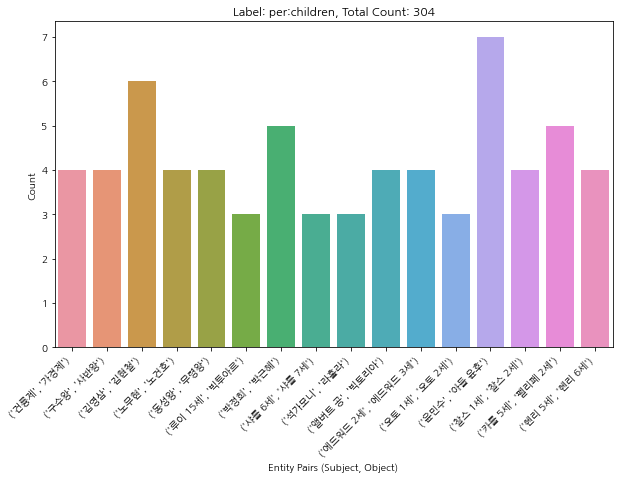

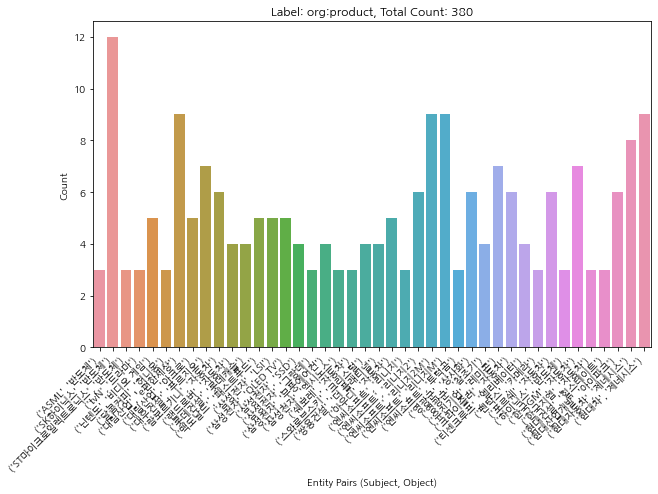

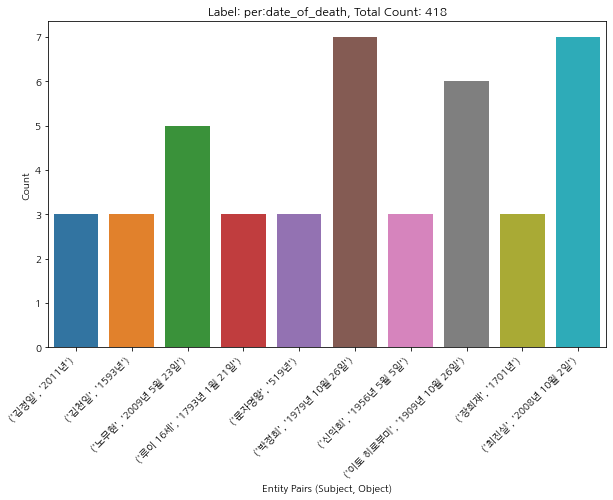

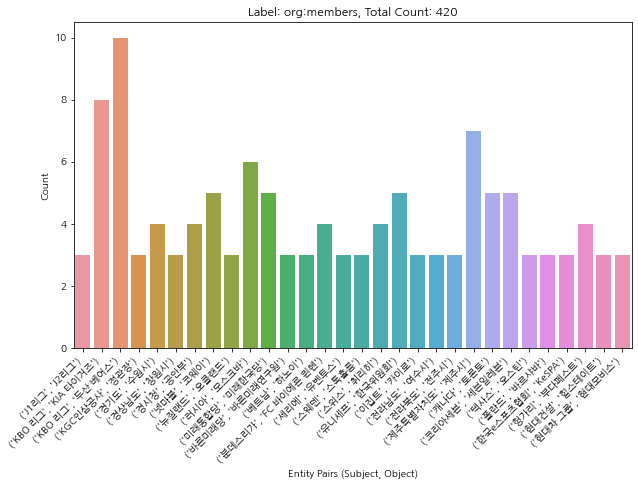

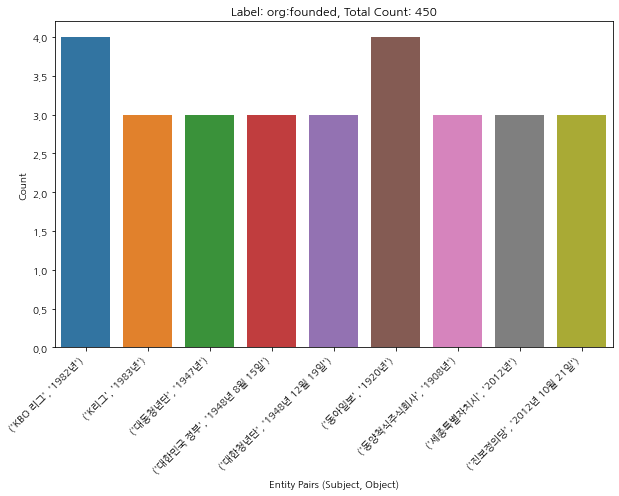

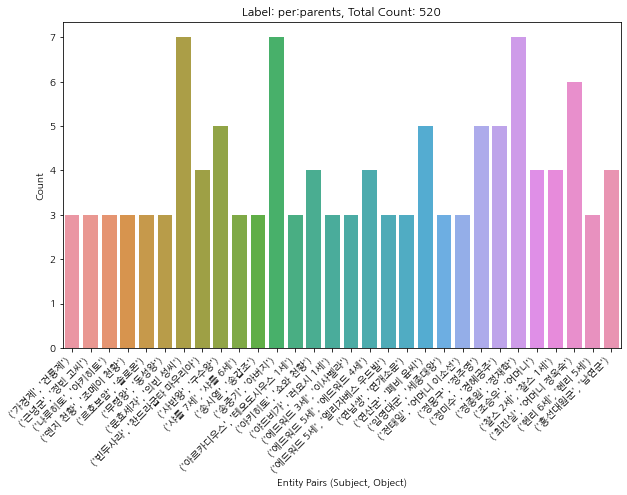

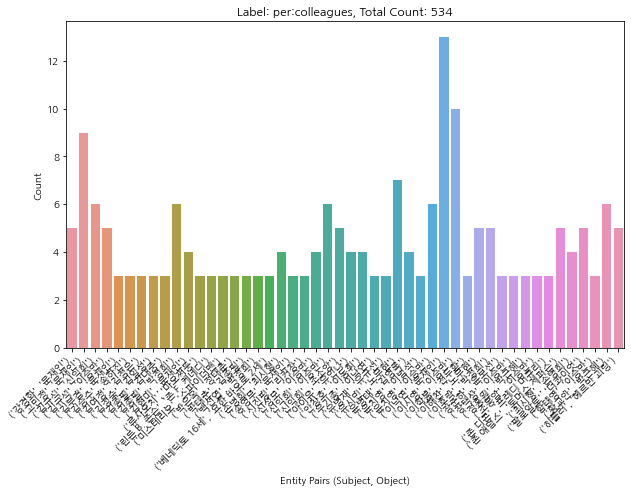

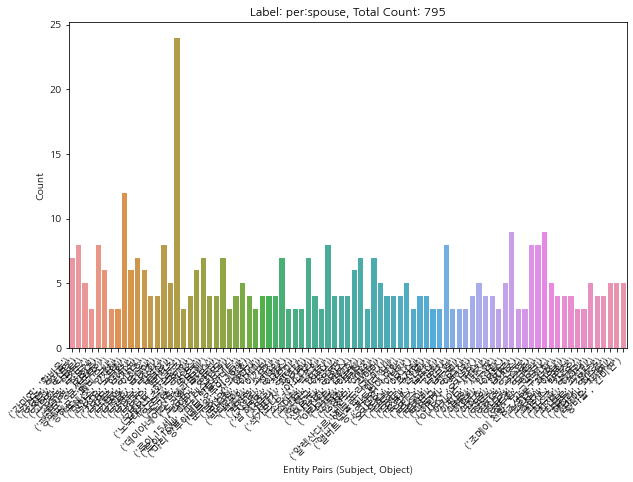

In [21]:
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

# Get total counts for each label
total_label_counts = train_df['label'].value_counts()

# Iterate over each unique label in the result DataFrame
for label in sorted(list(result['label'].unique()), key = lambda x: total_label_counts[x]):
    # Filter the DataFrame for the current label
    label_data = result[result['label'] == label].reset_index(drop=True)
    label_count = total_label_counts[label]
    
    if label_count >= 1000:
        continue

    # Create a bar plot for the current label
    plt.figure(figsize=(10, 6))
    sns.barplot(x=label_data[['subject_entity', 'object_entity']].apply(tuple, axis=1), y='count', data=label_data)
    plt.title(f"Label: {label}, Total Count: {label_count}")
    plt.xlabel("Entity Pairs (Subject, Object)")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.show()


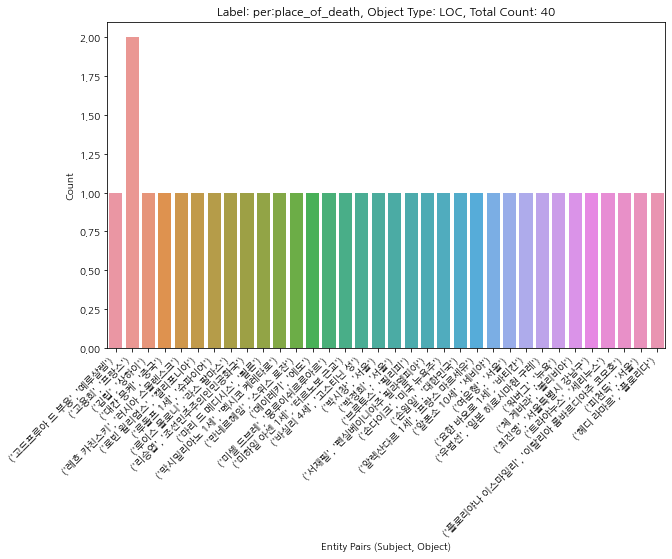

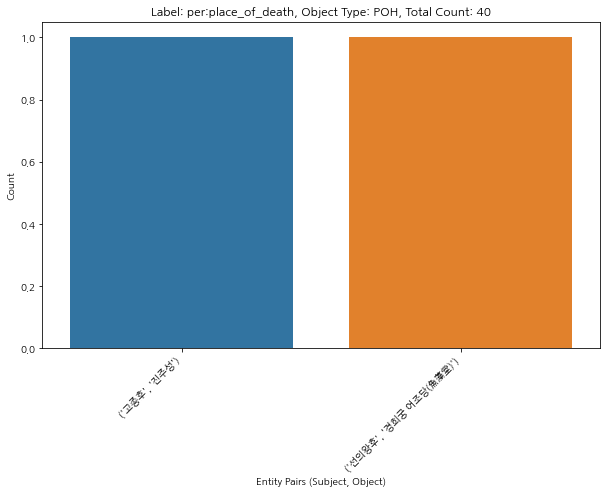

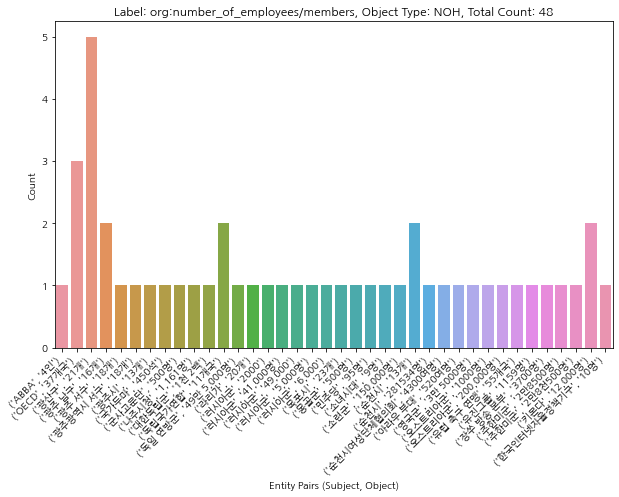

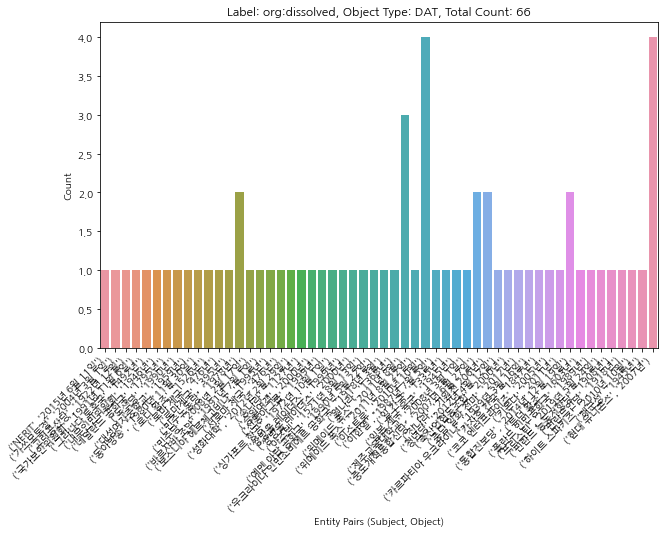

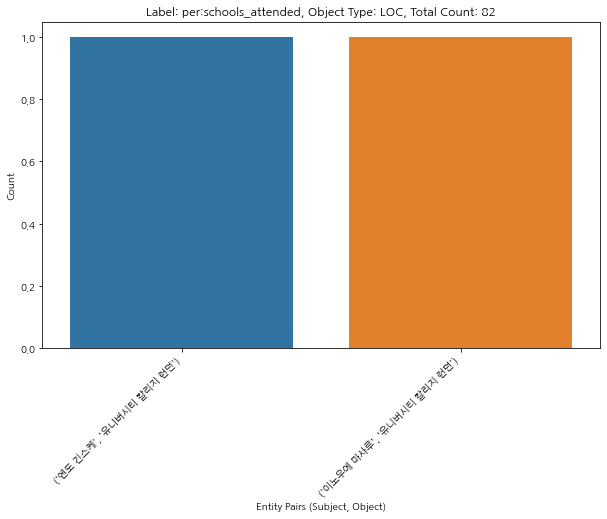

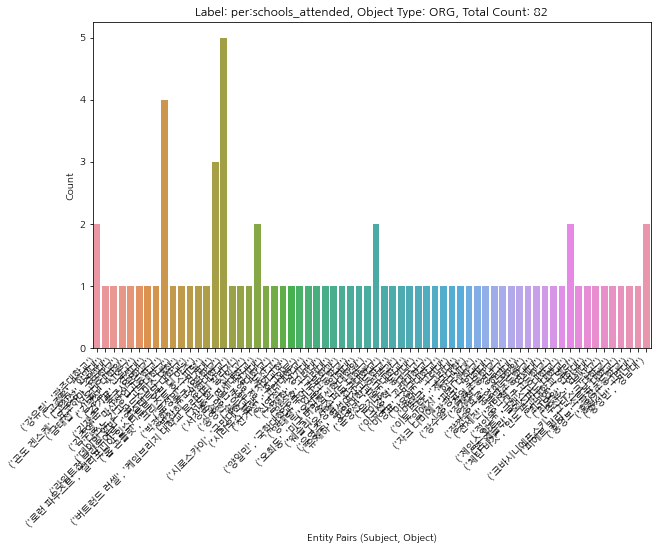

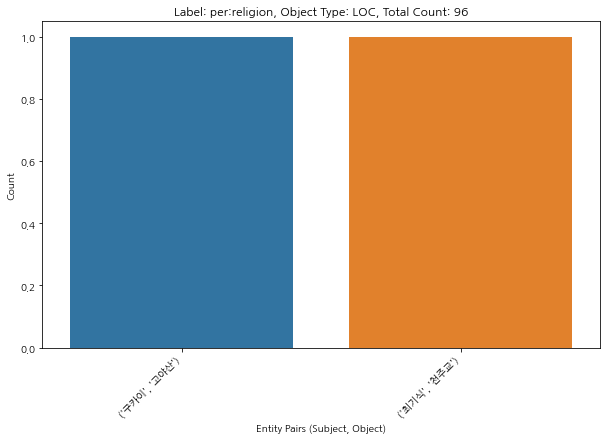

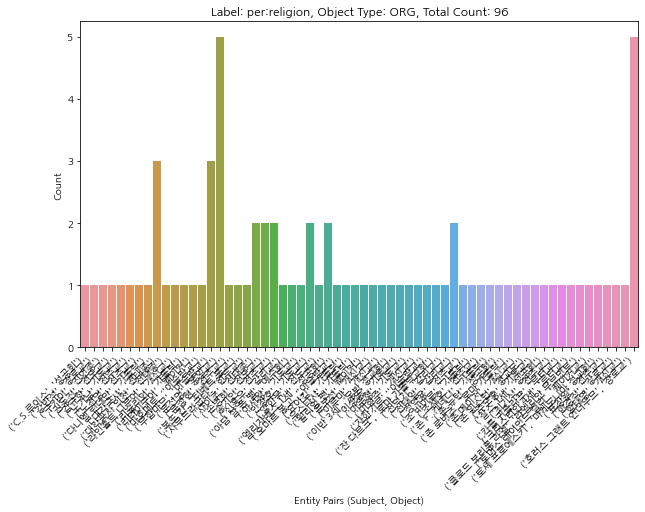

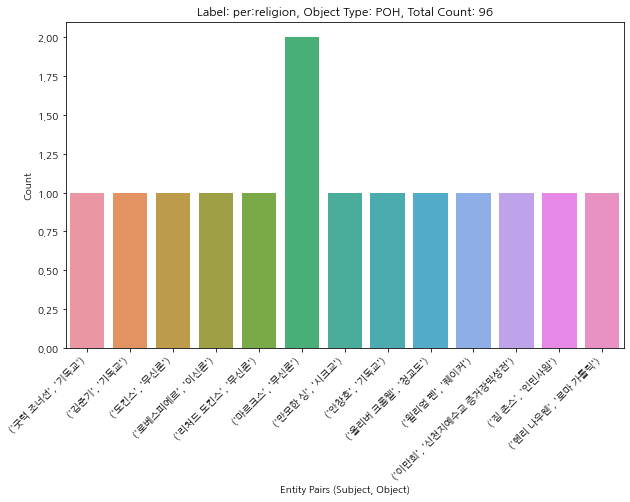

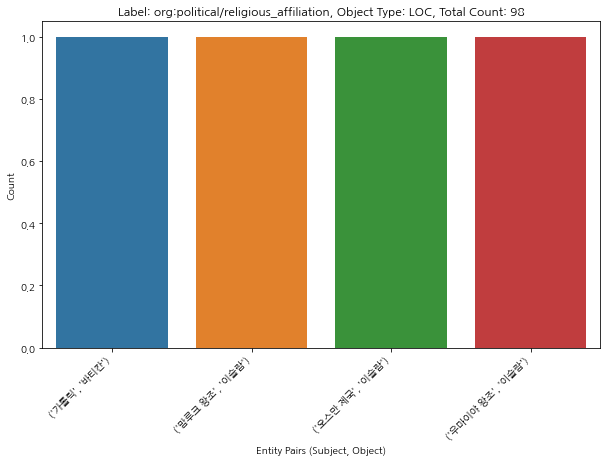

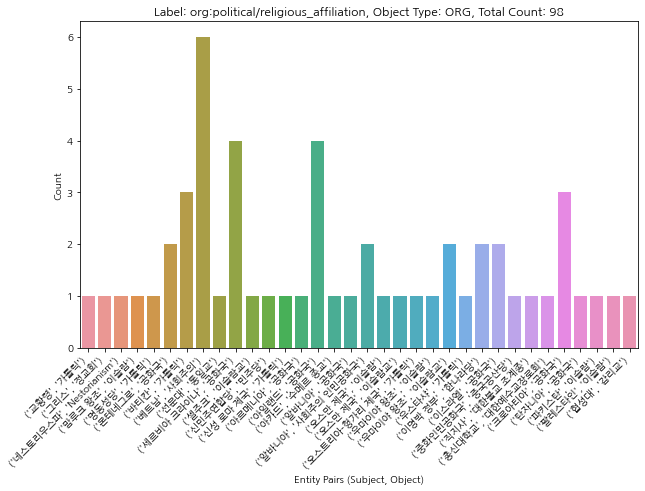

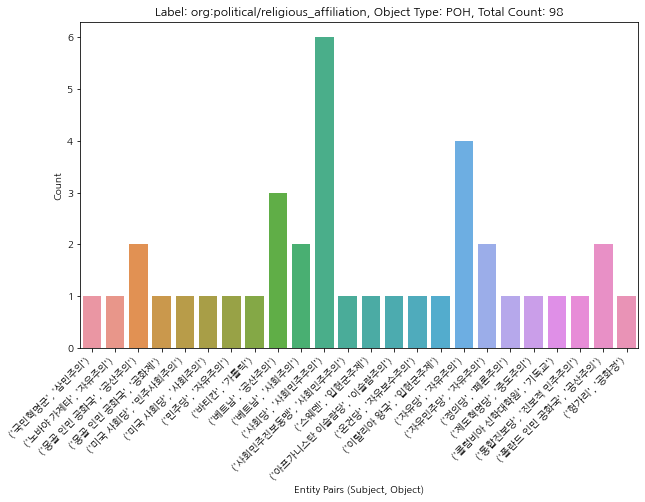

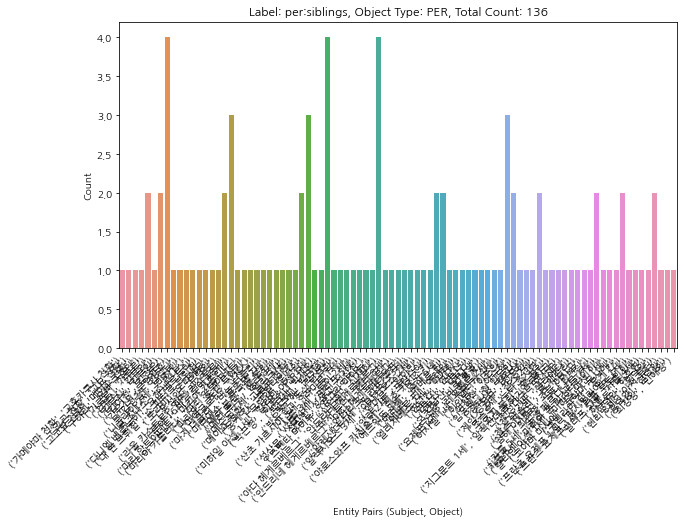

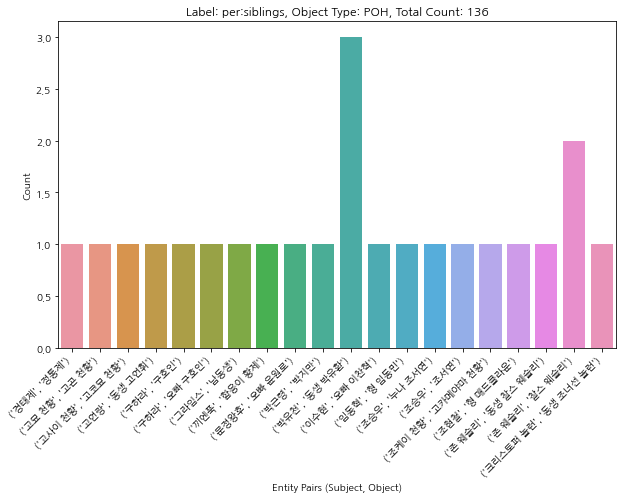

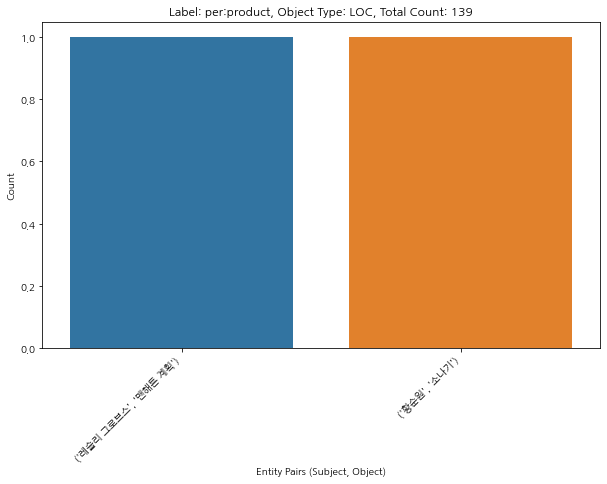

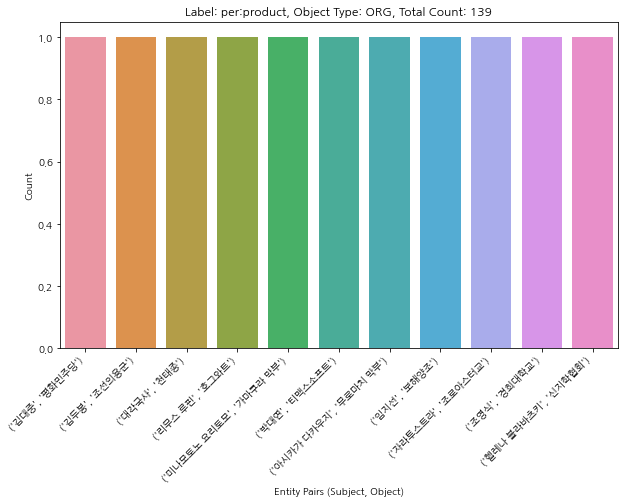

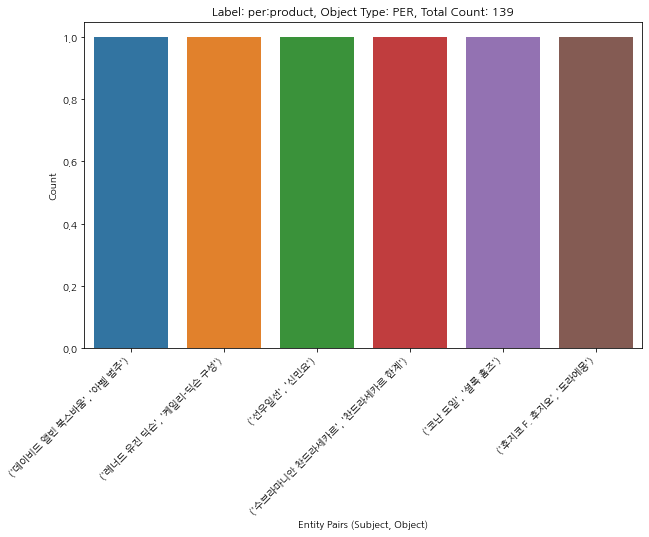

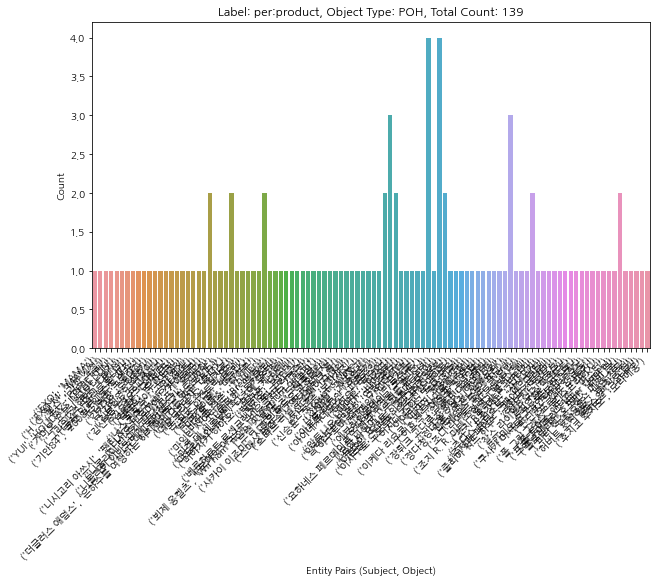

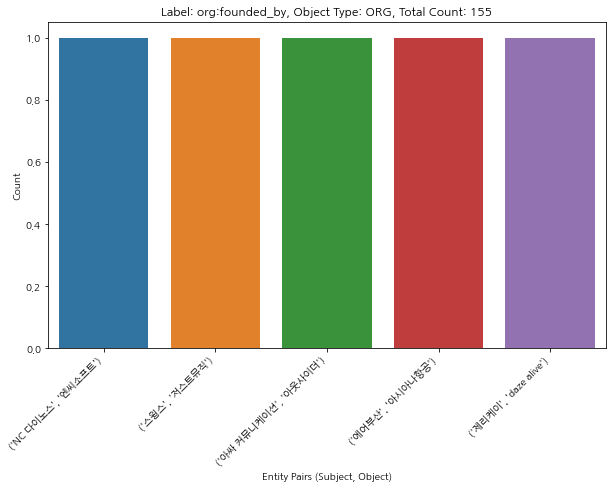

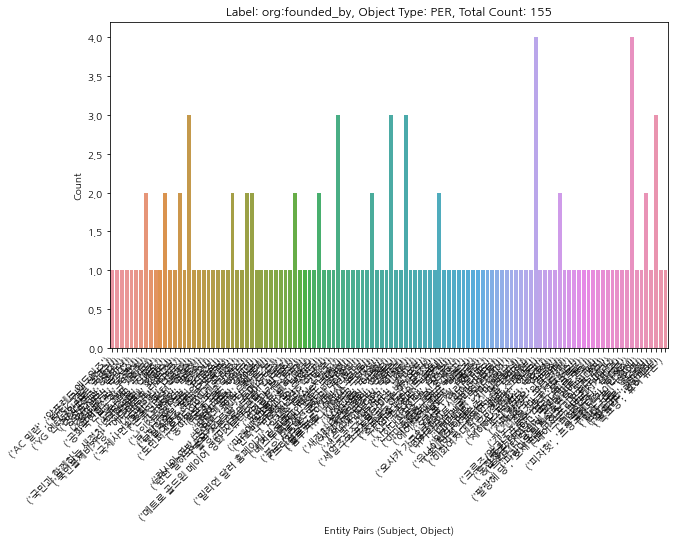

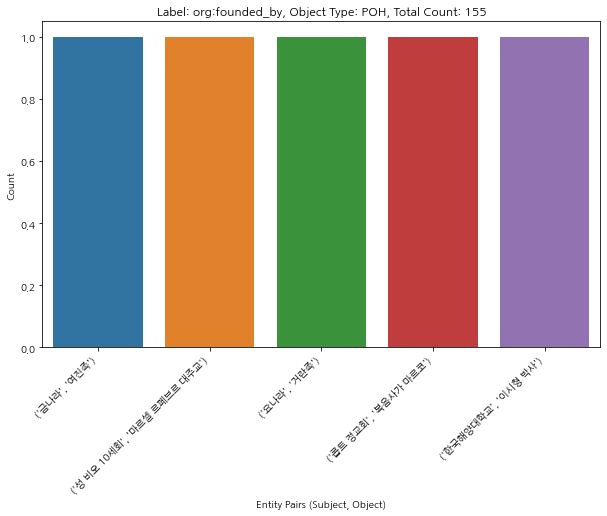

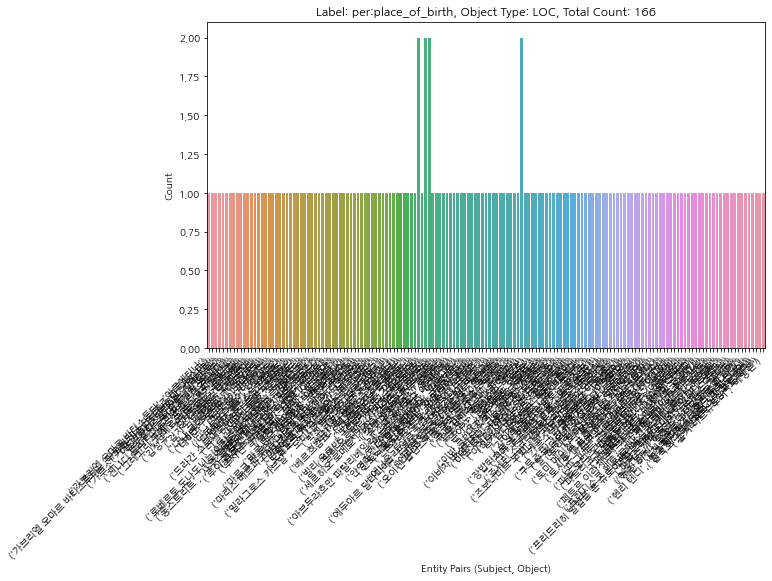

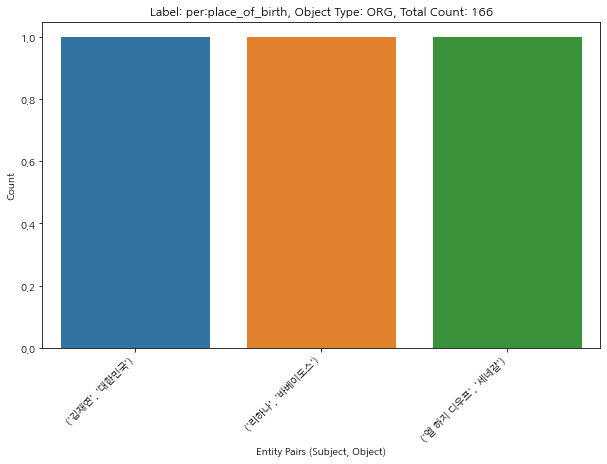

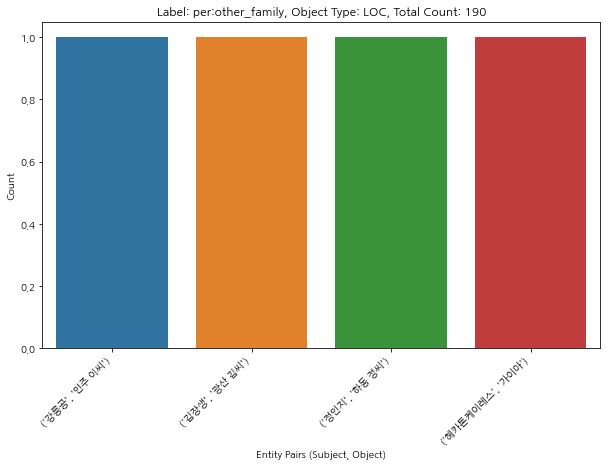

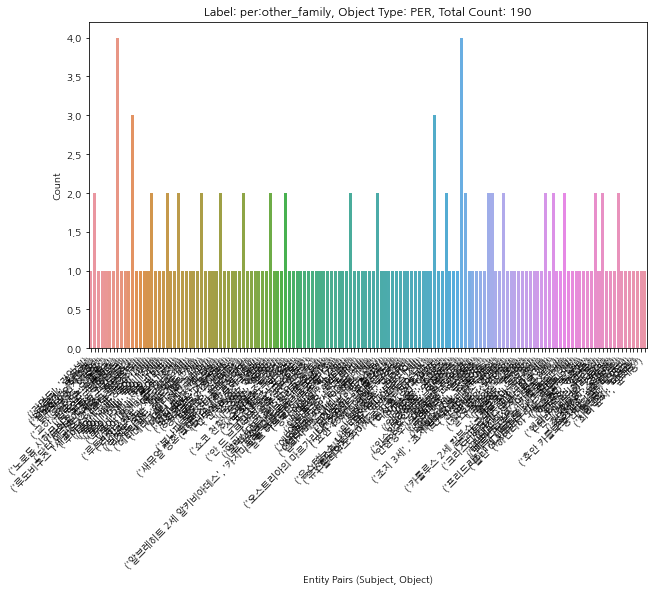

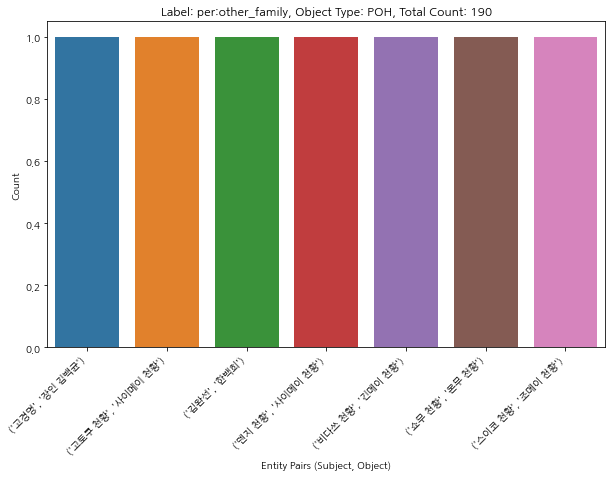

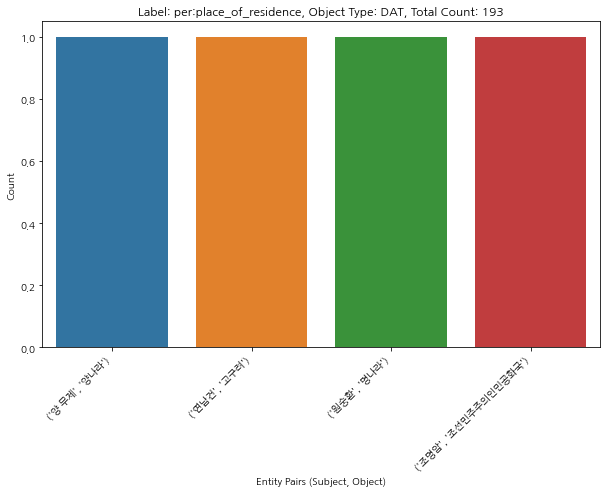

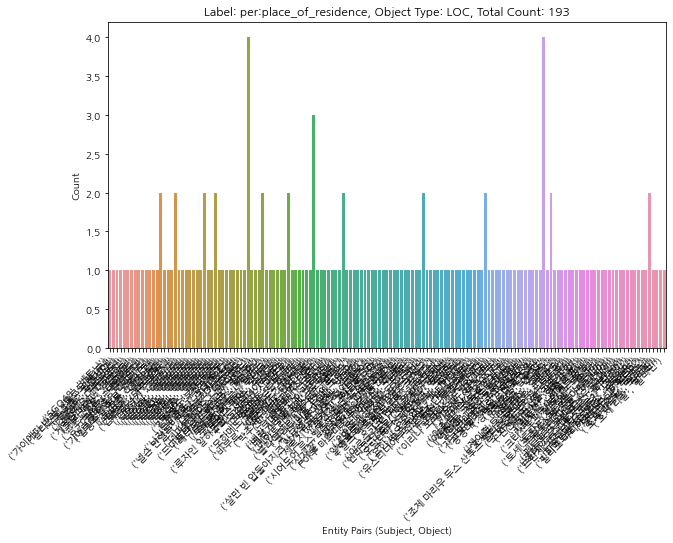

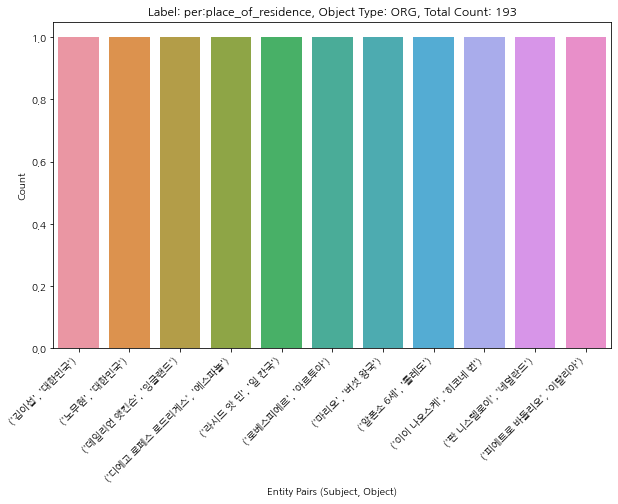

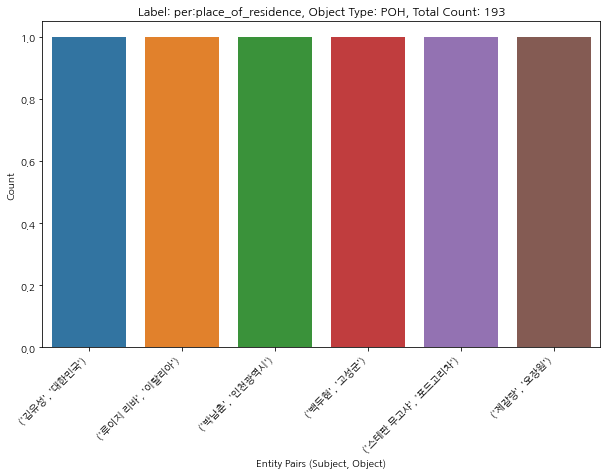

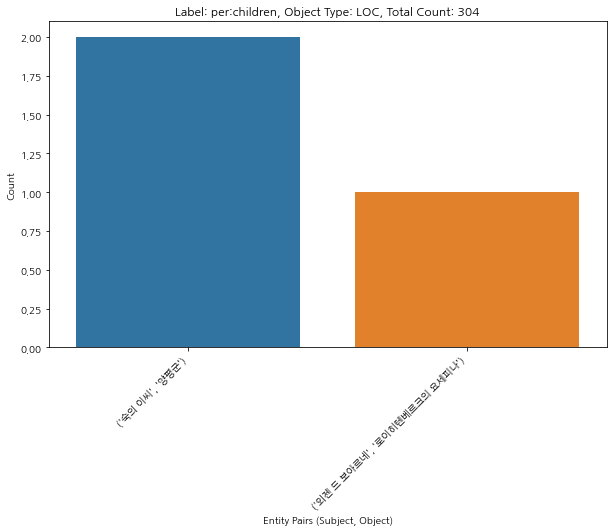

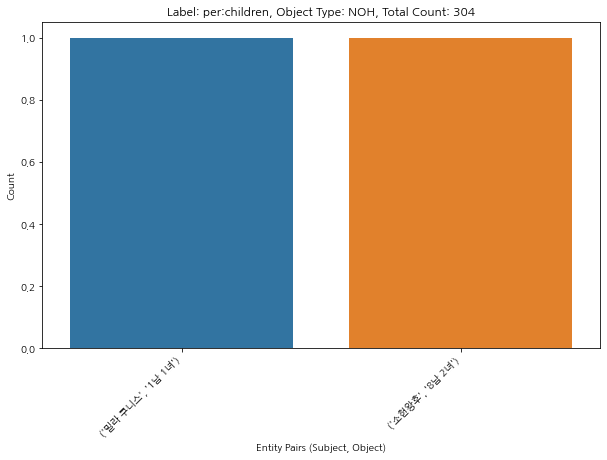

In [28]:
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

# Get total counts for each label
total_label_counts = train_df['label'].value_counts()

# Group by label, object_type, subject_entity, and object_entity and count the occurrences
result = train_df.groupby(['label', 'object_type', 'subject_entity', 'object_entity']).size().reset_index(name='count')

# Iterate over each unique label in the result DataFrame
for label in sorted(list(result['label'].unique()), key = lambda x: total_label_counts[x]):
    # Filter the DataFrame for the current label
    label_data = result[result['label'] == label].reset_index(drop=True)
    
    # Iterate over each unique object_type in the label_data DataFrame
    for object_type in label_data['object_type'].unique():
        # no_relation은 보지 말자
        label_data = result[result['label'] == label].reset_index(drop=True)
        label_count = total_label_counts[label]
    
        if label_count >= 1000:
            continue
        
        # Filter the label_data DataFrame for the current object_type
        object_type_data = label_data[label_data['object_type'] == object_type].reset_index(drop=True)
        
        label_count = total_label_counts[label]
        
        if object_type_data['count'].sum() < 2: 
            continue

        # Create a bar plot for the current label and object_type
        plt.figure(figsize=(10, 6))
        sns.barplot(x=object_type_data[['subject_entity', 'object_entity']].apply(tuple, axis=1), y='count', data=object_type_data)
        plt.title(f"Label: {label}, Object Type: {object_type}, Total Count: {label_count}")
        plt.xlabel("Entity Pairs (Subject, Object)")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.show()


## 추가사항
뭔가 val 할 때, 30개의 각 라벨에 대해 제대로 맞추지 못한 문장은 어떤거고, 그럼 다른거 어떤 걸 예측했는지. 그런걸 보면 좋을 것 같다. 그런 애들 할 때 페널티 더 주게.